<a href="https://colab.research.google.com/github/Farhanzii/Business-Inteligence-Batch-3/blob/main/M_Farhan__explanatory_model_analysis__fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment Instruction Exploratory Data Analysis

Assignment Instruction :

Salah satu perusahaan yang bergerak di bidang asuransi mengalami kesulitan dalam mengatasi dan mengendalikan jumlah kasus fraud. Anda sebagai data scientist yang bekerja di salah satu konsultan manajemen ternama diminta untuk melakukan otomatisasi pada pendeteksian fraud. Anda diberikan dataset dengan metadata sebagai berikut:
months_as_customer: lama user menjadi nasabah dalam hitungan bulan
* age: usia nasabah
* policy_number: nomor polis
* policy_bind_date: tanggal polis
* policy_state: wilayah polis, negara bagian
* policy_csl: Combined single limit polis
* policy_deductable: risiko yang ditanggung bersama
* policy_annual_premium: premi tahunan
* umbrella_limit: limit pembayaran risiko oleh perusahaan asuransi
* insured_zip: kode pos nasabah
* insured_sex: gender nasabah
* insured_education_level: tingkat pendidikan nasabah
* insured_occupation: pekerjaan nasabah
* insured_hobbies: hobi nasabah
* insured_relationship: status hubungan nasabah
* capital-gains: besar gains yang diperoleh dari ganti rugi
* capital-loss: besar loss yang diperoleh dari ganti rugi
* incident_date: tanggal insiden terjadi
* incident_type: tipe insiden
* collision_type: tipe tabrakan
* incident_severity: tingkah keparahan
* authorities_contacted: pihak berwajib yang dihubungi
* incident_state: lokasi insiden, negara bagian
* incident_city: kota terjadinya insiden
* incident_location: lokasi terjadinya insiden
* incident_hour_of_the_day: jam terjadinya insiden
* number_of_vehicles_involved: jumlah kendaraan yang ikut dalam insiden
* property_damage: apakah terdapat kerusakan properti? YES jika ya
* bodily_injuries: jumlah korban luka
* witness: jumlah saksi mata
* police_report_available: apakah terdapat laporan polisi? YES jika ya
* total_claim_amount: total klaim
* injury_claim: klaim untuk luka-luka
* property_claim: klaim untuk kerusakan properti
* vehicle_claim: klaim untuk kerusakan mobil
* auto_make: merek otomotif
* auto_model: model otomotif
* auto_year: tahun pembuatan mobil
* fraud_reported: apakah terlapor sebagai fraud? Y jika ya



# Intall Package and Importing Library





In [1]:
# Import Package
!pip install -U xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
# import pandas for data wrangling
import pandas as pd
# import numpy for vectorize data manipulation
import numpy as np
# import module for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# load statsmodel module 
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import train and test split method from scikit-learn
from sklearn.model_selection import train_test_split

# import metrics method for model evaluation
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc,roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

# load logistic regression model
from sklearn.linear_model import LogisticRegression

# Import KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# import decision tree model as surrogate model
from sklearn.tree import DecisionTreeClassifier

# import xgboost classifier
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV, cross_val_score

# load LimeTabularExplainer for LIME method
from lime.lime_tabular import LimeTabularExplainer 

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# for Q-Q plots
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Function
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def create_stacked_bar_percent(df,column_name):
        
    # Get the percentage of default by each group
    default_by_group = pd.crosstab(index=df['fraud_reported'],columns = df[column_name], normalize = 'columns')
    default_by_group = default_by_group[default_by_group.iloc[1].sort_values().index]
    
    # Round up to 2 decimal
    default_by_group = default_by_group.apply(lambda x: round(x,2))
    
    labels = default_by_group.columns
    list1 = default_by_group.iloc[0].to_list()
    list2 = default_by_group.iloc[1].to_list()
    
    list1_name = "Not Fraud"
    list2_name = "Fraud"
    title = f" %Fraud by {column_name}"
    xlabel = column_name
    ylabel = "Number of Fraud"
    
    fig, ax = plt.subplots(figsize=(8,8),dpi=100)
    bar_width = 0.5
    
    ax1 = ax.bar(labels,list1, bar_width, label = list1_name)
    ax2 = ax.bar(labels,list2, bar_width, bottom = list1, label = list2_name)

    ax.set_title(title, fontweight = "bold",fontsize=12)
    ax.set_xlabel(xlabel, fontweight = "bold",fontsize=12)
    ax.set_ylabel(ylabel, fontweight = "bold",fontsize=12)
    ax.legend(loc="upper right")
    
    plt.xticks(list(range(len(labels))), labels,rotation=90)
    plt.yticks(fontsize=12)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f"{h1:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f"{h2:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.show()

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()


# Importing Files


In [61]:
### Loading Dataset
url = 'https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/car_insurance_fraud_dataset/insuranceFraud.csv'
df = pd.read_csv(url)

# Data Observation

In [63]:
### Data Inspection
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,1/25/2015,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,1/21/2015,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2/22/2015,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,1/10/2015,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2/17/2015,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [64]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


In [65]:
#### Mengecek data duplicated
df.duplicated().sum()

0

In [66]:
### Mengecek Value dalam Kolom
for x in df:
    print(f"Nilai Data {x}")
    print(f"{df[x].unique()}")
    

Nilai Data months_as_customer
[328 228 134 256 137 165  27 212 235 447  60 121 180 473  70 140 160 196
 460 217 370 413 237   8 257 202 224 241  64 166 155 114 149 147  62 289
 431 199  79 116  37 106 269 265 163 355 175 192 430  91 223 195  22 439
  94  11 151 154 245 119 215 295 254 107 478 128 338 271 222 120 270 319
 194 227 244  78 200 284 275 153  31  41 127  61 207 219  80 325  29 239
 279 350 464 118 298  87 261 453 210 168 390 258 225 164 255 206 203 211
 274  81 280 112  24  93 171 124 287 122 398 214 209  82 193 288 104 101
 375 461 428  45 136 216 278 108  14 276  47  73 294 324  53 426 111  86
 296 125 177 238 449 252 359  19 285  30 342 468 343 404  63 335 142 272
  69  38 281 246 330 362 371 377 172  99 249 190 174  95   2 117 242 440
  20 208 156 232  84 394  35 369 332 243 264  32 259 186 201 436 189 105
  88  40  59  39 123 231 247  48 267 286 253  10 158   1  85 233 266  97
 399 305 129 283  96 176 159 290 299  66 334 429  15 230 250  65 475  77
 229 110 292 451 150 

Terdapat angka Null yang bukan brupa karakter '?' dan terdapat data outlier yang berupa data minus pada umbrella_limit sehingga harus di transformasi

# Question 1: Missing Value Identification

Identifikasi berapa banyak nilai null yang terdapat di dalam dataset. Perhatian: nilai null pada dataset tidak selalu NA atau NULL **(10 poin)**


In [67]:
### Cek Kolom Umbrella_Limit
df['umbrella_limit'].sort_values(ascending=True)

290    -1000000
0             0
623           0
624           0
625           0
         ...   
657     9000000
458     9000000
975     9000000
430    10000000
115    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [68]:
df['umbrella_limit'].iloc[290] = 1000000

In [69]:
# Cek Ulang Nilai Kolom
df['umbrella_limit'].iloc[290]

1000000

In [70]:
### Merubah Simbol Data pada dataset
df = df.replace("?", np.nan)

In [71]:
### Menghitung nilai null dalam dataset
Count_null = df.isnull().sum()
print(Count_null[Count_null >= 0].sort_values(ascending=False))

property_damage                360
police_report_available        343
collision_type                 178
auto_model                       0
auto_make                        0
vehicle_claim                    0
property_claim                   0
injury_claim                     0
total_claim_amount               0
incident_severity                0
witnesses                        0
bodily_injuries                  0
auto_year                        0
number_of_vehicles_involved      0
incident_hour_of_the_day         0
incident_location                0
incident_city                    0
incident_state                   0
authorities_contacted            0
months_as_customer               0
age                              0
insured_zip                      0
policy_number                    0
policy_bind_date                 0
policy_state                     0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit      

In [72]:
### Menghitung Total nilai null dalam dataset
Count_null = df.isnull().sum().sum()
print('Total Count =', (Count_null))

Total Count = 881


Melalui inspeksi terhadap data terdapat data yang hilang dan outlier dengan simbol '?' bukan NaN dan data minus

# Question 2: Missing Value Treatment

Lakukan treatment pada kolom yang bernilai NA atau NULL. Berikan alasan anda mengapa anda melakukan treatment tertentu pada nilai NA tersebut. **(10 poin)**


In [73]:
### Merubah Nilai Null menjadi kategori baru
def Merubah_Nilai_Null(df,ColName):
     df[ColName] = np.where(df[ColName].isnull(),"Undocumented",df[ColName])
### Melihat kategori baru
for Columns in ['property_damage','police_report_available','collision_type']:
    Merubah_Nilai_Null(df,Columns)
### Melihat gambaran hasil perubahan
df[['property_damage','police_report_available','collision_type']]

,property_damage,police_report_available,collision_type
0,YES,YES,Side Collision
1,Undocumented,Undocumented,Undocumented
2,NO,NO,Rear Collision
3,Undocumented,NO,Front Collision
4,NO,NO,Undocumented
...,...,...,...
995,YES,Undocumented,Front Collision
996,YES,Undocumented,Rear Collision
997,Undocumented,YES,Side Collision
998,Undocumented,YES,Rear Collision


In [74]:
### Menghitung Jumlah Kategori
print("Jumlah Kategori pada Kolom berikut: ")
for ColName in df[['property_damage','police_report_available','collision_type']]:
    print("{} = {}".format(ColName,len(df[ColName].unique())))

Jumlah Kategori pada Kolom berikut: 
property_damage = 3
police_report_available = 3
collision_type = 4


In [75]:
### Menghitung Total nilai null dalam dataset
Count_null = df.isnull().sum().sum()
print('Total Count =', (Count_null))

Total Count = 0


In [76]:
### Menghitung nilai null dalam dataset
Count_null = df.isnull().sum()
Count_null[Count_null >= 0].sort_values(ascending=False)

months_as_customer             0
witnesses                      0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
police_report_available        0
incident_severity              0
total_claim_amount             0
injury_claim                   0
property_claim                 0
vehicle_claim                  0
auto_make                      0
auto_model                     0
auto_year                      0
authorities_contacted          0
collision_type                 0
age                            0
insured_zip                    0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_sex                    0
incident_t

In [77]:
### Melihat Persentase Tiap value
for x in ['property_damage','police_report_available','collision_type']:
  print(f"{df[x].value_counts()/len(df)*100}")

Undocumented    36.0
NO              33.8
YES             30.2
Name: property_damage, dtype: float64
Undocumented    34.3
NO              34.3
YES             31.4
Name: police_report_available, dtype: float64
Rear Collision     29.2
Side Collision     27.6
Front Collision    25.4
Undocumented       17.8
Name: collision_type, dtype: float64


Data missing memiliki proporsi yang cukup tinggi dengan data yang berupa kategorikal sehingga tidak dapat diimputasi jadi diubah menjadi suatu kategori baru lalu nanti dapat dilihat untuk analisa kedepannya apakah perubahan nilai tersebut kedalam kategori baru adalah hal yang tepat

# Question 3: Target Variable Analysis

Lakukan analisis pada beberapa variabel prediktor dan interpretasikan analisisnya  dengan mengaitkan analisanya dengan variabel target. Pilihlah beberapa variabel yang akan digunakan untuk modeling berdasarkan hasil analisa. **(20 poin)**

In [78]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

dalam kasus fraud asuransi, hal yang membuat orang orang melakukan fraud adalah karena adanya keinginan untuk mendapatkan uang dengan cara instant dengan melaporkan kejadian kecelakaan palsu. kolom kolom yang relevan terhadap fraud adalah  policy_csl,umbrella_limit,insured_occupation,capital-gains,capital-loss,incident_type,collision_type,incident-severity,incident_city,'property_damage', 'bodily_injuries','witnesses', 'police_report_available', 'total_claim_amount',
'injury_claim', 'property_claim', 'vehicle_claim', <br>

target : fraud_reported <br>

untuk 'insured_sex', 'insured_education_level', 'insured_occupation','insured_hobbies','insured_relationship' akan diperiksa apakah mengandung informasi

In [79]:
col_keep = ['policy_number','policy_csl','policy_annual_premium', 'umbrella_limit','insured_occupation',
       'insured_relationship', 'capital-gains', 'capital-loss','incident_type','insured_sex',
       'insured_education_level', 'insured_hobbies','collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state','number_of_vehicles_involved', 
       'property_damage', 'bodily_injuries','witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'fraud_reported',"incident_date"]

df = df[col_keep]
#policy_number as index
df = df.set_index('policy_number')
df.head()

,policy_csl,policy_annual_premium,umbrella_limit,insured_occupation,insured_relationship,capital-gains,capital-loss,incident_type,insured_sex,insured_education_level,insured_hobbies,collision_type,incident_severity,authorities_contacted,incident_state,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported,incident_date
policy_number,,,,,,,,,,,,,,,,,,,,,,,,,,
521585,250/500,1406.91,0,craft-repair,husband,53300,0,Single Vehicle Collision,MALE,MD,sleeping,Side Collision,Major Damage,Police,SC,1,YES,1,2,YES,71610,6510,13020,52080,Y,1/25/2015
342868,250/500,1197.22,5000000,machine-op-inspct,other-relative,0,0,Vehicle Theft,MALE,MD,reading,Undocumented,Minor Damage,Police,VA,1,Undocumented,0,0,Undocumented,5070,780,780,3510,Y,1/21/2015
687698,100/300,1413.14,5000000,sales,own-child,35100,0,Multi-vehicle Collision,FEMALE,PhD,board-games,Rear Collision,Minor Damage,Police,NY,3,NO,2,3,NO,34650,7700,3850,23100,N,2/22/2015
227811,250/500,1415.74,6000000,armed-forces,unmarried,48900,-62400,Single Vehicle Collision,FEMALE,PhD,board-games,Front Collision,Major Damage,Police,OH,1,Undocumented,1,2,NO,63400,6340,6340,50720,Y,1/10/2015
367455,500/1000,1583.91,6000000,sales,unmarried,66000,-46000,Vehicle Theft,MALE,Associate,board-games,Undocumented,Minor Damage,None,NY,1,NO,0,1,NO,6500,1300,650,4550,N,2/17/2015


In [80]:
#convert y and n in fraud reported
df['fraud_reported'] = df["fraud_reported"].replace(["Y","N"],[1,0])
df['fraud_reported'].unique()

array([1, 0])

In [81]:
#training and test split
#change data type
df["incident_date"] = pd.to_datetime(df["incident_date"])
df[df["incident_date"]>"2015-02-15"].shape[0]/df[df["incident_date"]<="2015-02-15"].shape[0]

0.30718954248366015

In [82]:
#splitting data to be train and testing
df_train = df[df["incident_date"]<="2015-02-15"].copy()
df_test = df[df["incident_date"]>"2015-02-15"].copy()

In [83]:
df_train  = df_train.drop("incident_date",axis=1)
df_test  = df_test.drop("incident_date",axis=1)

splitting tidak dilakukan secara acak karena, berdasarkan experience, laporan kecurangan selalu memiliki perubahaan behavior dari waktu ke waktu sehingga relevan dengan mempeljari behavior masa lalu untuk memprediksi terjadinya kecerungan masa akan datang

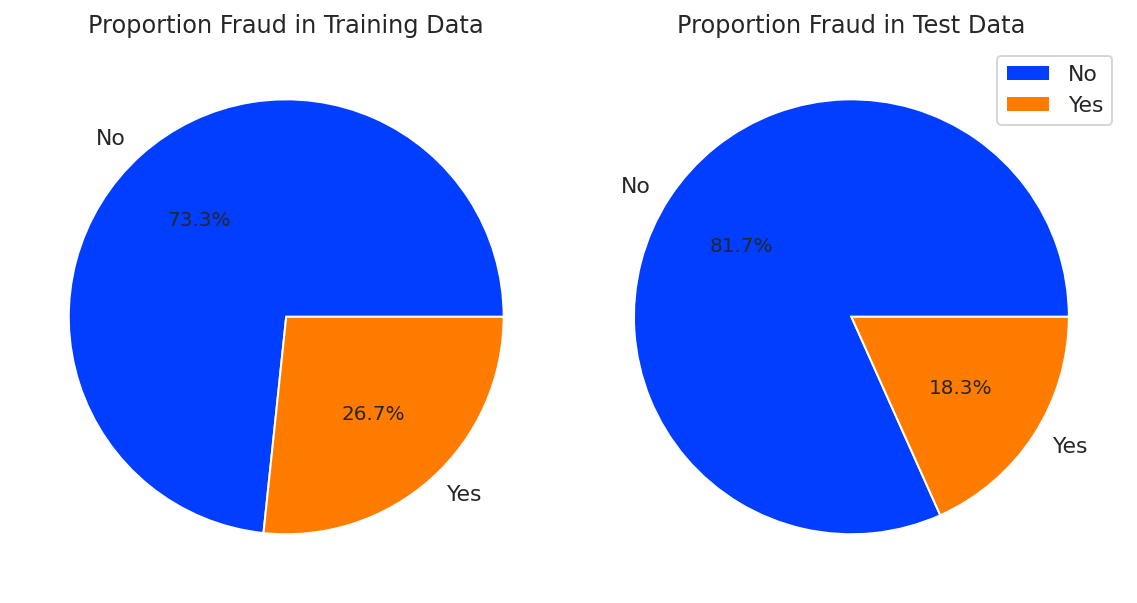

In [84]:
#target baseline
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.pie(df_train['fraud_reported'].value_counts(),autopct='%1.1f%%',labels=["No","Yes"])
plt.title('Proportion Fraud in Training Data')

plt.subplot(122)
plt.pie(df_test['fraud_reported'].value_counts(),autopct='%1.1f%%',labels=["No","Yes"])
plt.title('Proportion Fraud in Test Data')

plt.legend()
plt.tight_layout()
plt.show()

1.perbandingan fraud dan tidak fraud imbalance, tetapi tidak ekstreme. <br>
2.pada periode waktu  2015-01-01 hingga 2015-02-15 telah terjadi kasus fraud sebesar 26.7% atau 204 kasus dan pada periode waktu 2015-02-16 hingga 2015-03-01 telah terjadi kasus fraud. <br>


In [85]:
#split numeric and categorical
num  = df_train.select_dtypes(exclude="object").columns
cat = df_train.select_dtypes(include="object").columns

In [86]:
len(num)

12

In [87]:
df_train[num].head()

,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported
policy_number,,,,,,,,,,,,
521585,1406.91,0,53300,0,1,1,2,71610,6510,13020,52080,1
342868,1197.22,5000000,0,0,1,0,0,5070,780,780,3510,1
227811,1415.74,6000000,48900,-62400,1,1,2,63400,6340,6340,50720,1
104594,1351.10,0,0,0,3,0,2,64100,6410,6410,51280,1
413978,1333.35,0,0,-77000,3,0,0,78650,21450,7150,50050,0


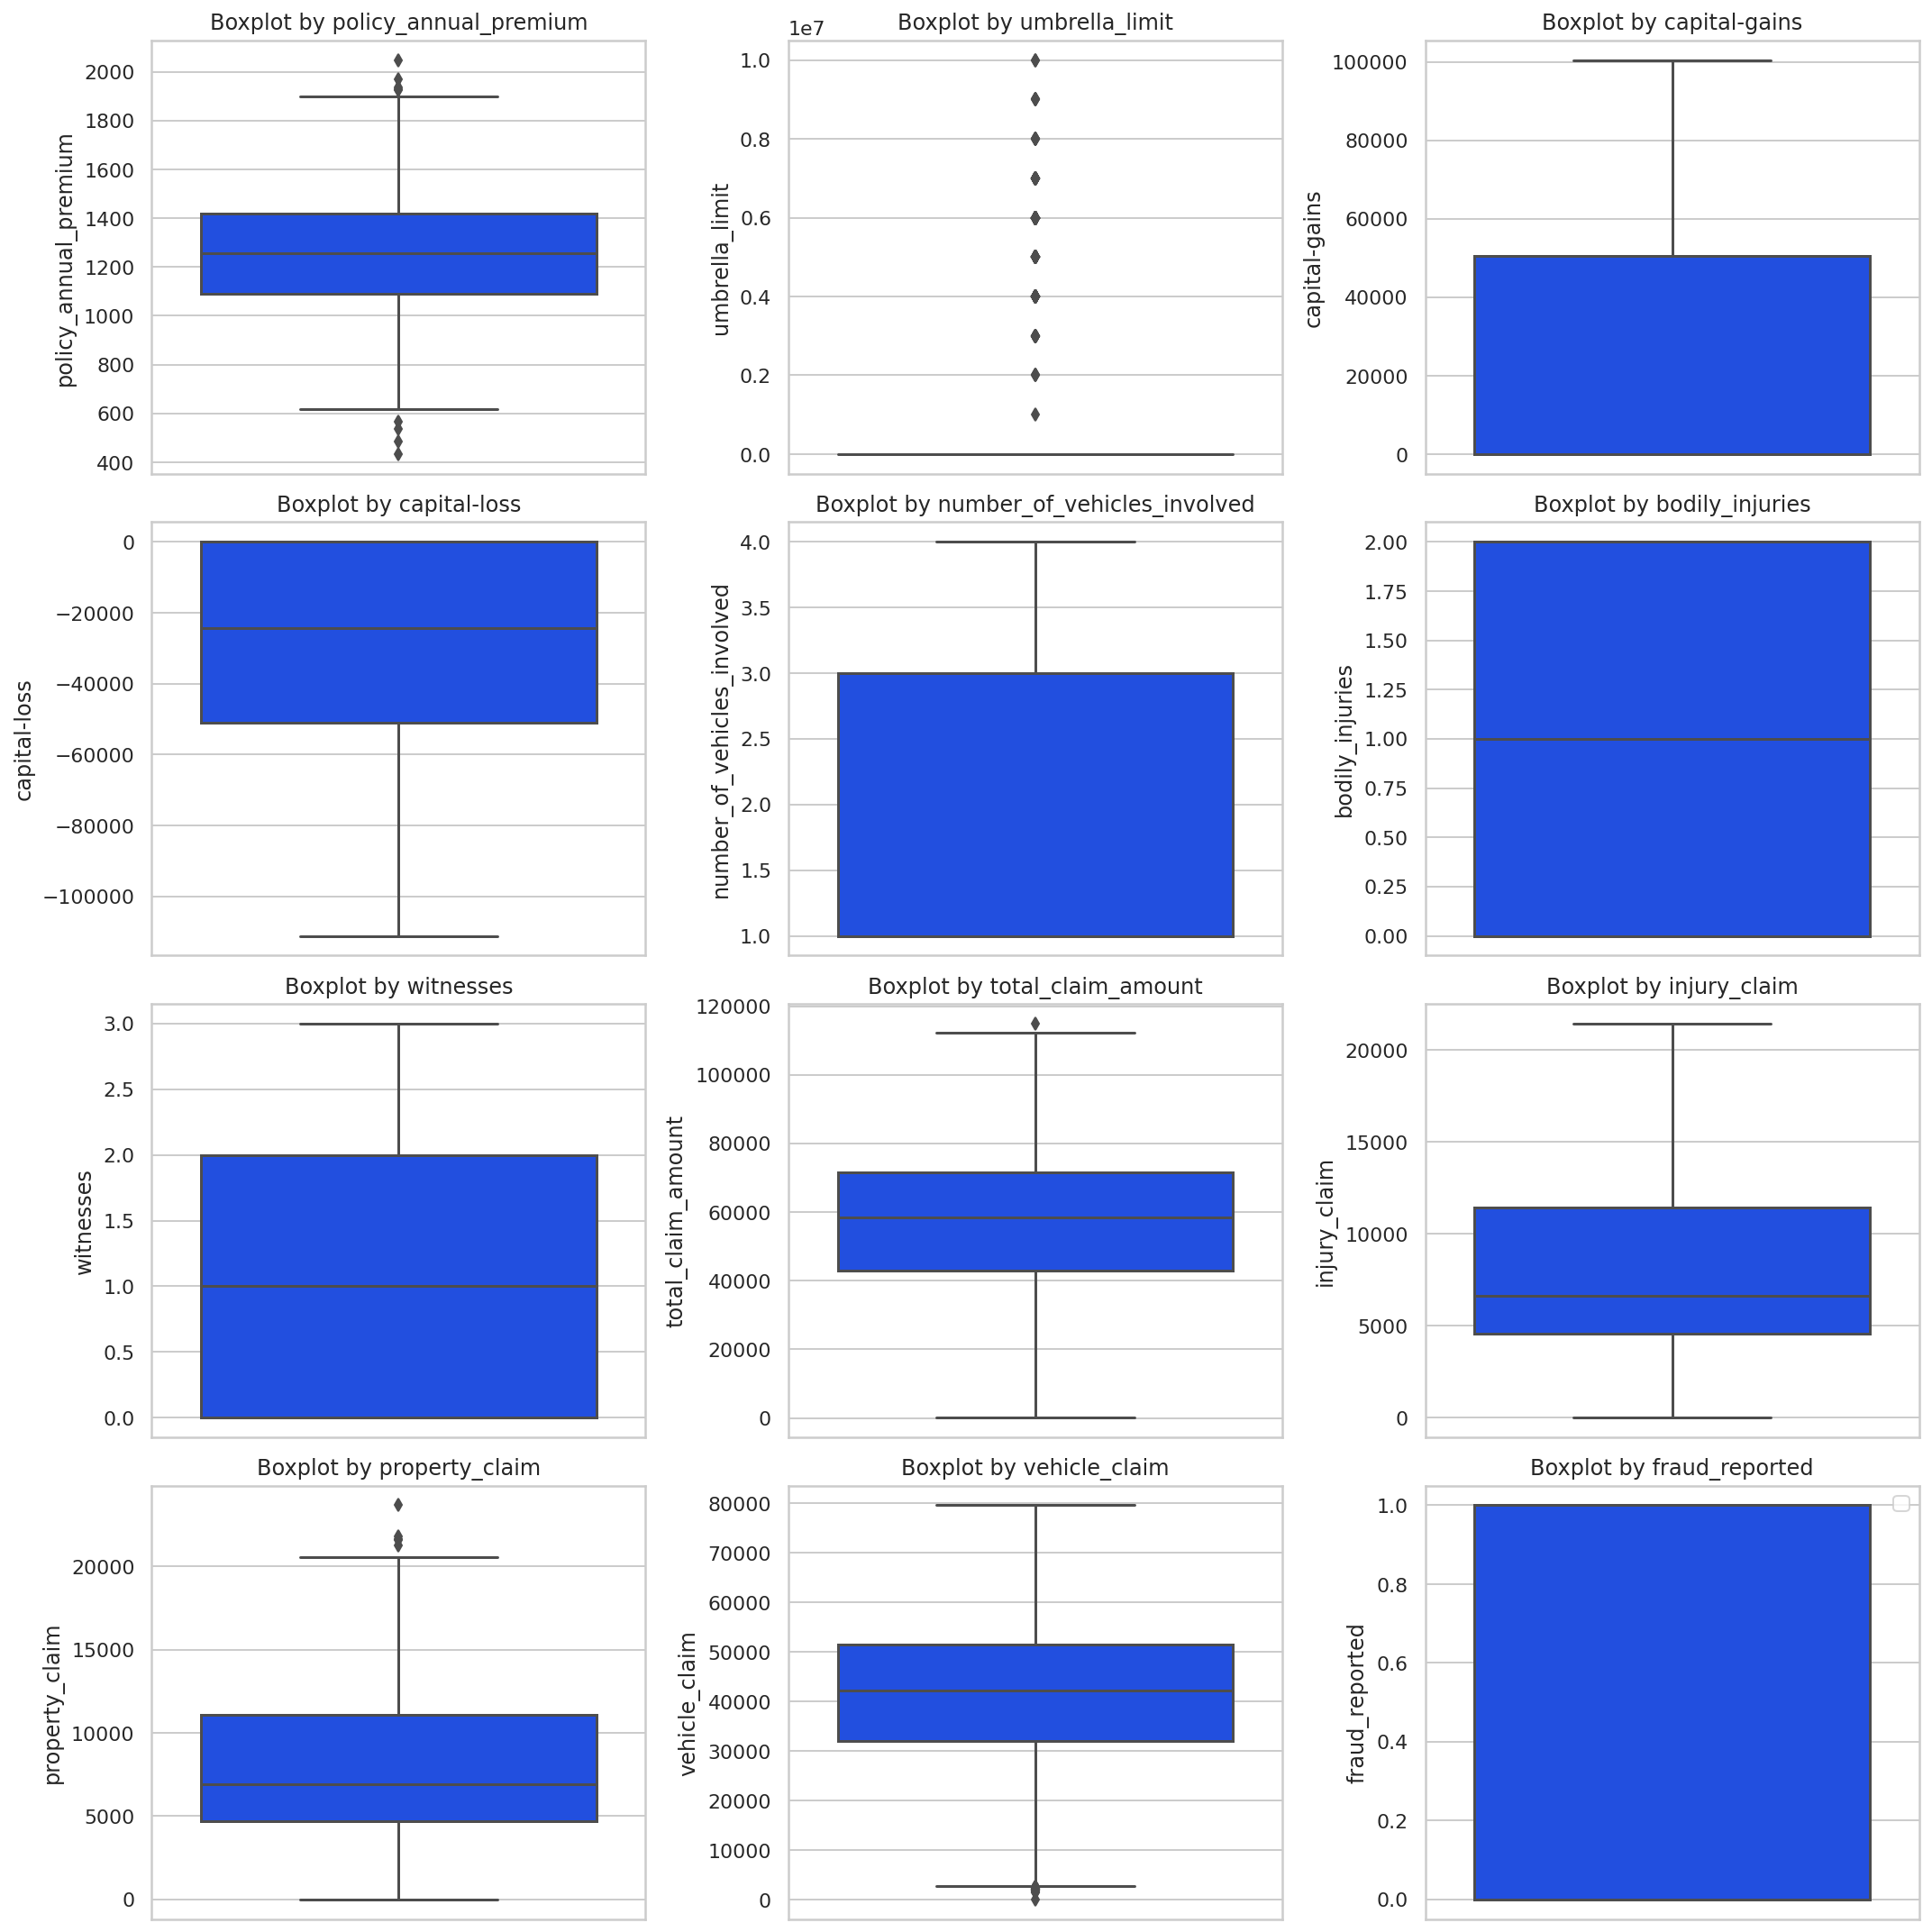

In [88]:
#Outliers check
plt.figure(figsize=(15,15))

for x in range(0,len(num)):
  plt.subplot(4,3,x+1)
  sns.boxplot(data=df_train,y=df_train[num[x]])
  plt.title(f"Boxplot by {num[x]}")
  plt.tight_layout()
plt.legend(loc="best")
plt.show()

terdapat bebrapa kolom yang outliers tetapi tidak lah ekstreme dan masih kategory yang wajar, sehingga tidak akan di treament, untuk kolom umbrella limit outliers terlihat ekstreme tetapi pada kenyataannya memang terdapat limit yang berbeda beda untuk tiap kasuk, sehingga tidak dapat dikatakan sebagai outliers

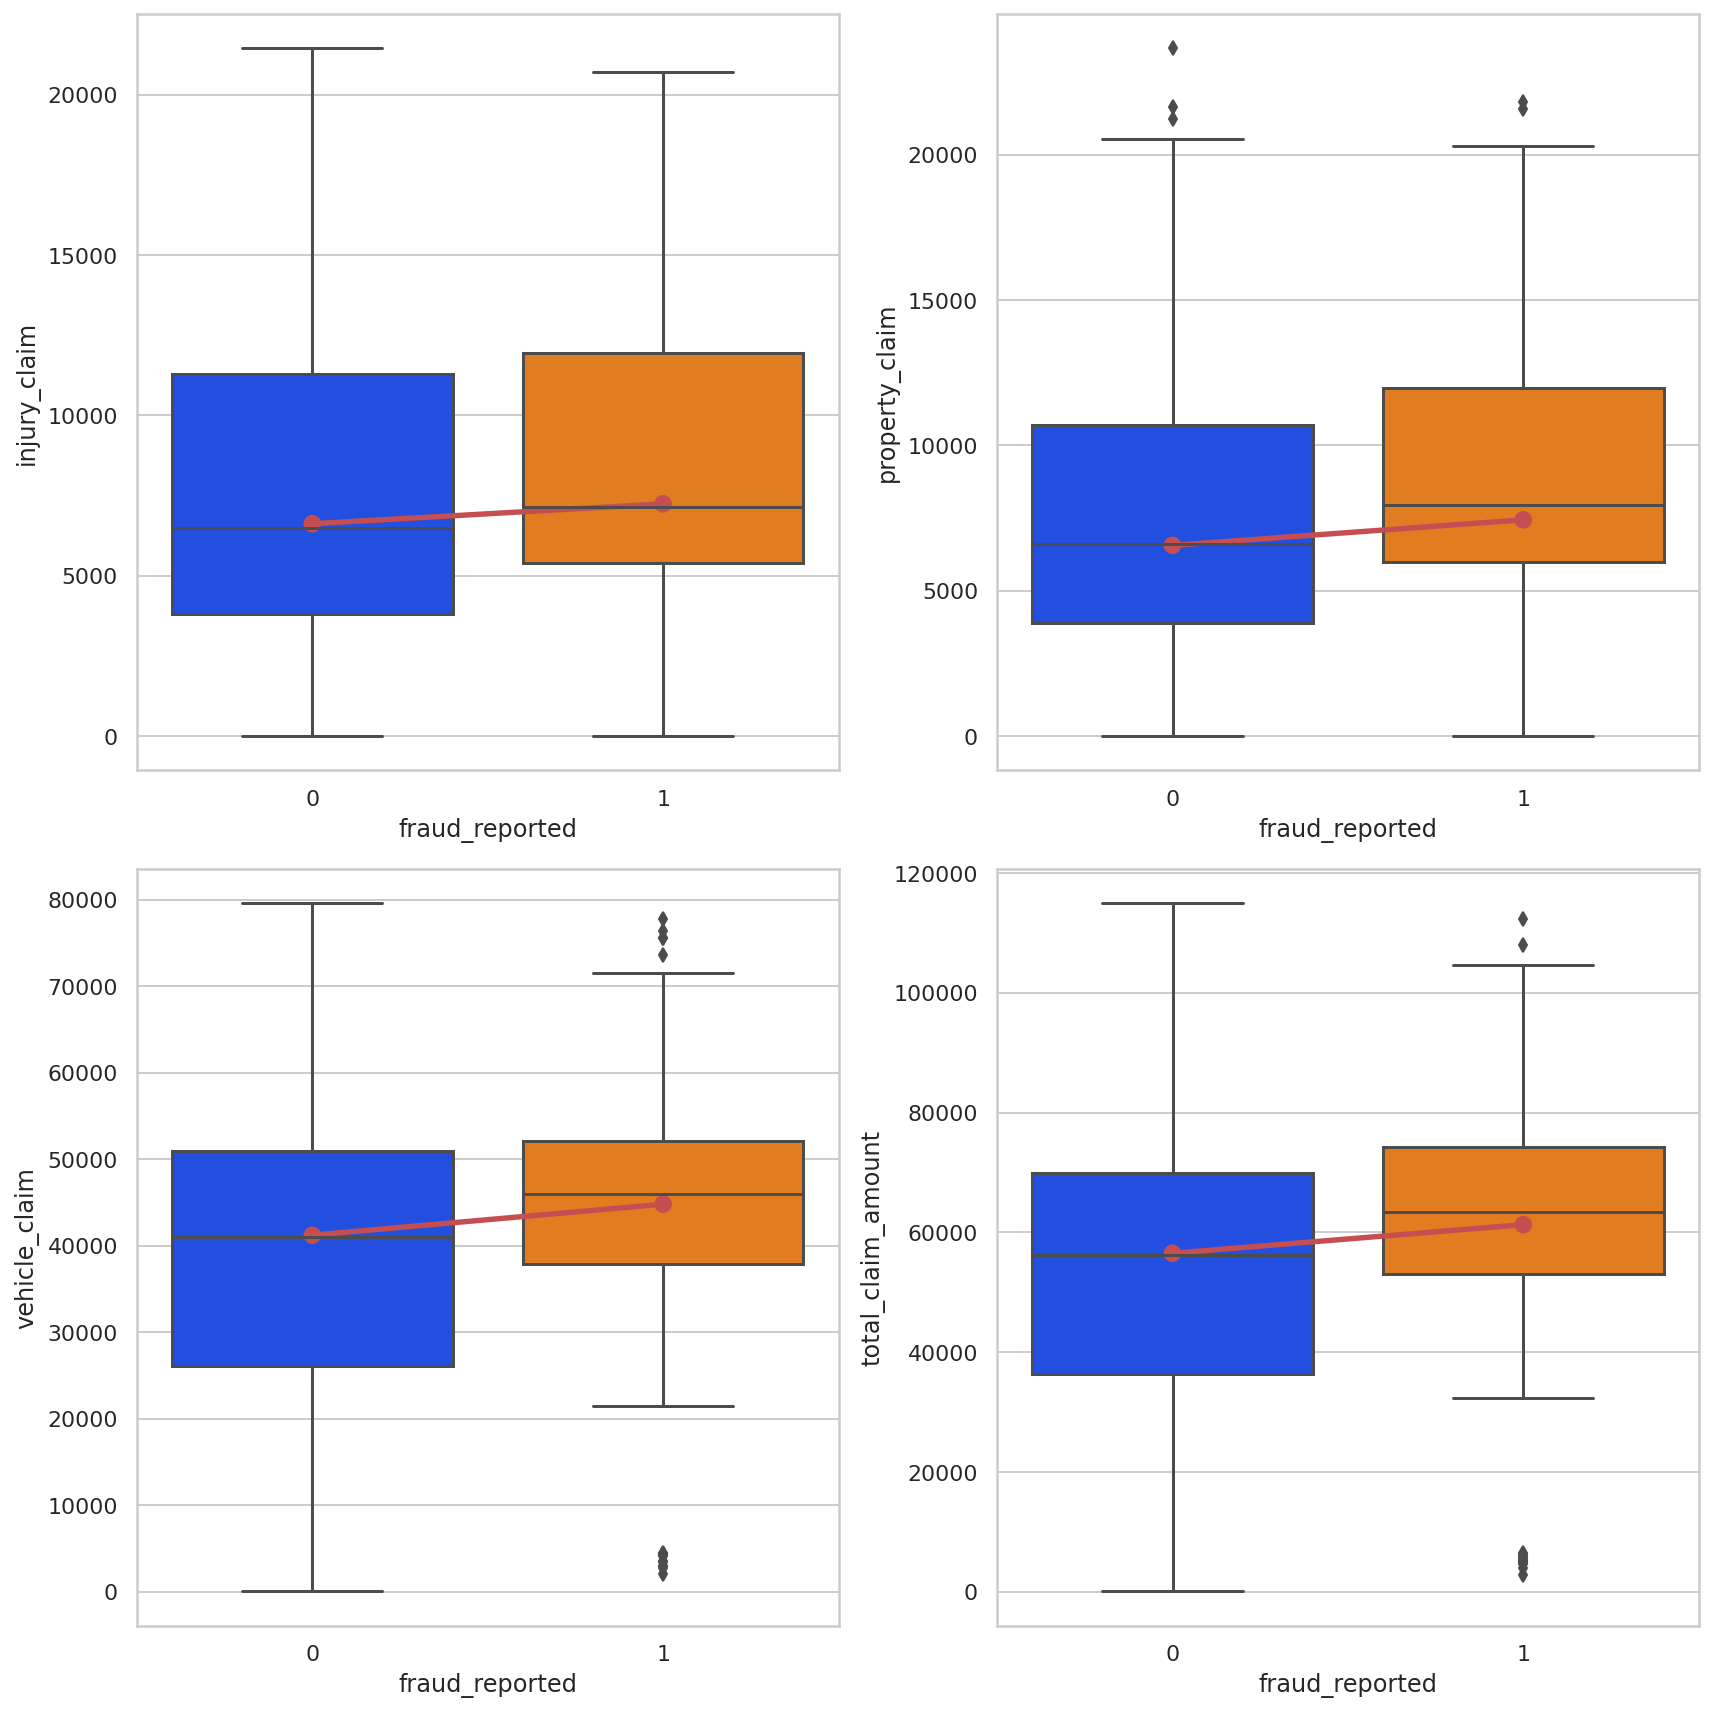

In [89]:
claim = ["injury_claim","property_claim","vehicle_claim","total_claim_amount"]

plt.figure(figsize=(12,12))
for x in range(0,len(claim)):
  plt.subplot(2,2,x+1)
  sns.boxplot(data=df_train,x='fraud_reported',y=claim[x],dodge =True)
  sns.pointplot(x='fraud_reported', y=claim[x], data=df.groupby('fraud_reported', as_index=False).median(),color='r')
  plt.tight_layout()
plt.show()

terliaht bahwa, orang orang yang fraud melakukan klaim yang lebih tinggi dari yang tidak fraud, tentunya memang karena ingin mendapatkan lebih banyak duit dengan membuat laporan palsu. Jika diperhatikan ada kasus fraud dimana nilai claimnya mendekati 0

In [90]:
df_train[(df_train["fraud_reported"]==1)&(df_train["total_claim_amount"]<20000)]

,policy_csl,policy_annual_premium,umbrella_limit,insured_occupation,insured_relationship,capital-gains,capital-loss,incident_type,insured_sex,insured_education_level,insured_hobbies,collision_type,incident_severity,authorities_contacted,incident_state,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported
policy_number,,,,,,,,,,,,,,,,,,,,,,,,,
342868,250/500,1197.22,5000000,machine-op-inspct,other-relative,0,0,Vehicle Theft,MALE,MD,reading,Undocumented,Minor Damage,Police,VA,1,Undocumented,0,0,Undocumented,5070,780,780,3510,1
608513,100/300,848.07,3000000,exec-managerial,not-in-family,31000,-30200,Vehicle Theft,MALE,JD,chess,Undocumented,Minor Damage,None,VA,1,YES,2,1,Undocumented,5720,1040,520,4160,1
602410,250/500,1463.07,0,armed-forces,own-child,0,0,Vehicle Theft,MALE,MD,skydiving,Undocumented,Trivial Damage,Police,WV,1,Undocumented,1,1,NO,5300,530,530,4240,1
779075,100/300,1348.32,0,craft-repair,wife,37600,-37600,Vehicle Theft,FEMALE,Associate,cross-fit,Undocumented,Trivial Damage,Police,NY,1,NO,2,1,Undocumented,4730,860,860,3010,1
832746,500/1000,994.74,0,adm-clerical,own-child,0,-55300,Parked Car,FEMALE,High School,polo,Undocumented,Minor Damage,Police,SC,1,NO,2,2,YES,5580,620,620,4340,1
903203,500/1000,814.96,6000000,priv-house-serv,not-in-family,68500,0,Parked Car,FEMALE,PhD,chess,Undocumented,Trivial Damage,Police,NC,1,Undocumented,2,2,NO,6400,640,1280,4480,1
714738,500/1000,791.47,0,armed-forces,unmarried,0,0,Vehicle Theft,MALE,Masters,chess,Undocumented,Minor Damage,Police,NC,1,NO,1,2,NO,6300,630,1260,4410,1
550294,500/1000,1526.61,0,handlers-cleaners,not-in-family,0,-32900,Vehicle Theft,MALE,Masters,chess,Undocumented,Minor Damage,Police,SC,1,YES,2,2,Undocumented,4620,840,840,2940,1
276804,100/300,995.70,5000000,priv-house-serv,unmarried,0,0,Parked Car,FEMALE,JD,chess,Undocumented,Trivial Damage,Police,PA,1,Undocumented,2,1,Undocumented,5000,500,1000,3500,1


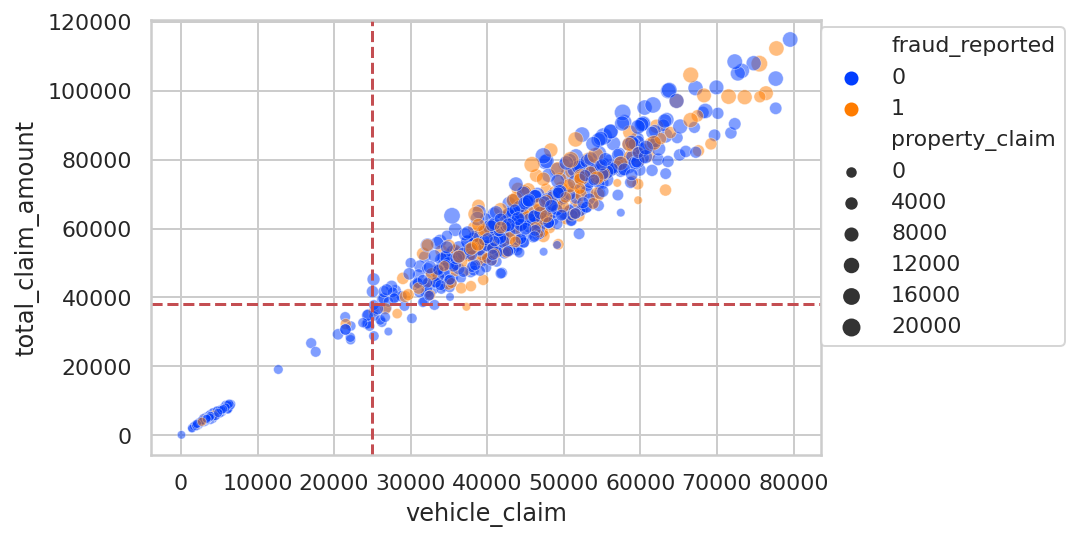

In [91]:
sns.scatterplot(data=df_train,x="vehicle_claim",y="total_claim_amount",size="property_claim",hue="fraud_reported",alpha=0.5)
plt.axvline(x=25000,color="r",linestyle="--")
plt.axhline(y=38000,color="r",linestyle="--")
plt.legend(loc=(1,0.25))

seperti yang terlihat bahwa banyak fraud terjadi ketika total claim diatas 39000 dan vehicle diatas 25000 ribu

In [92]:
df_train["warning_claim"] = np.where((df_train["vehicle_claim"]<=25000)&(df_train["total_claim_amount"]<=38000),0,1)
df_test["warning_claim"] = np.where((df_test["vehicle_claim"]<=25000)&(df_test["total_claim_amount"]<=38000),0,1)

In [93]:
df_train.groupby("warning_claim").agg({"fraud_reported":[len,"sum","mean"]})

fraud_reported               
                         len  sum      mean
warning_claim                              
0                        146   13  0.089041
1                        619  191  0.308562

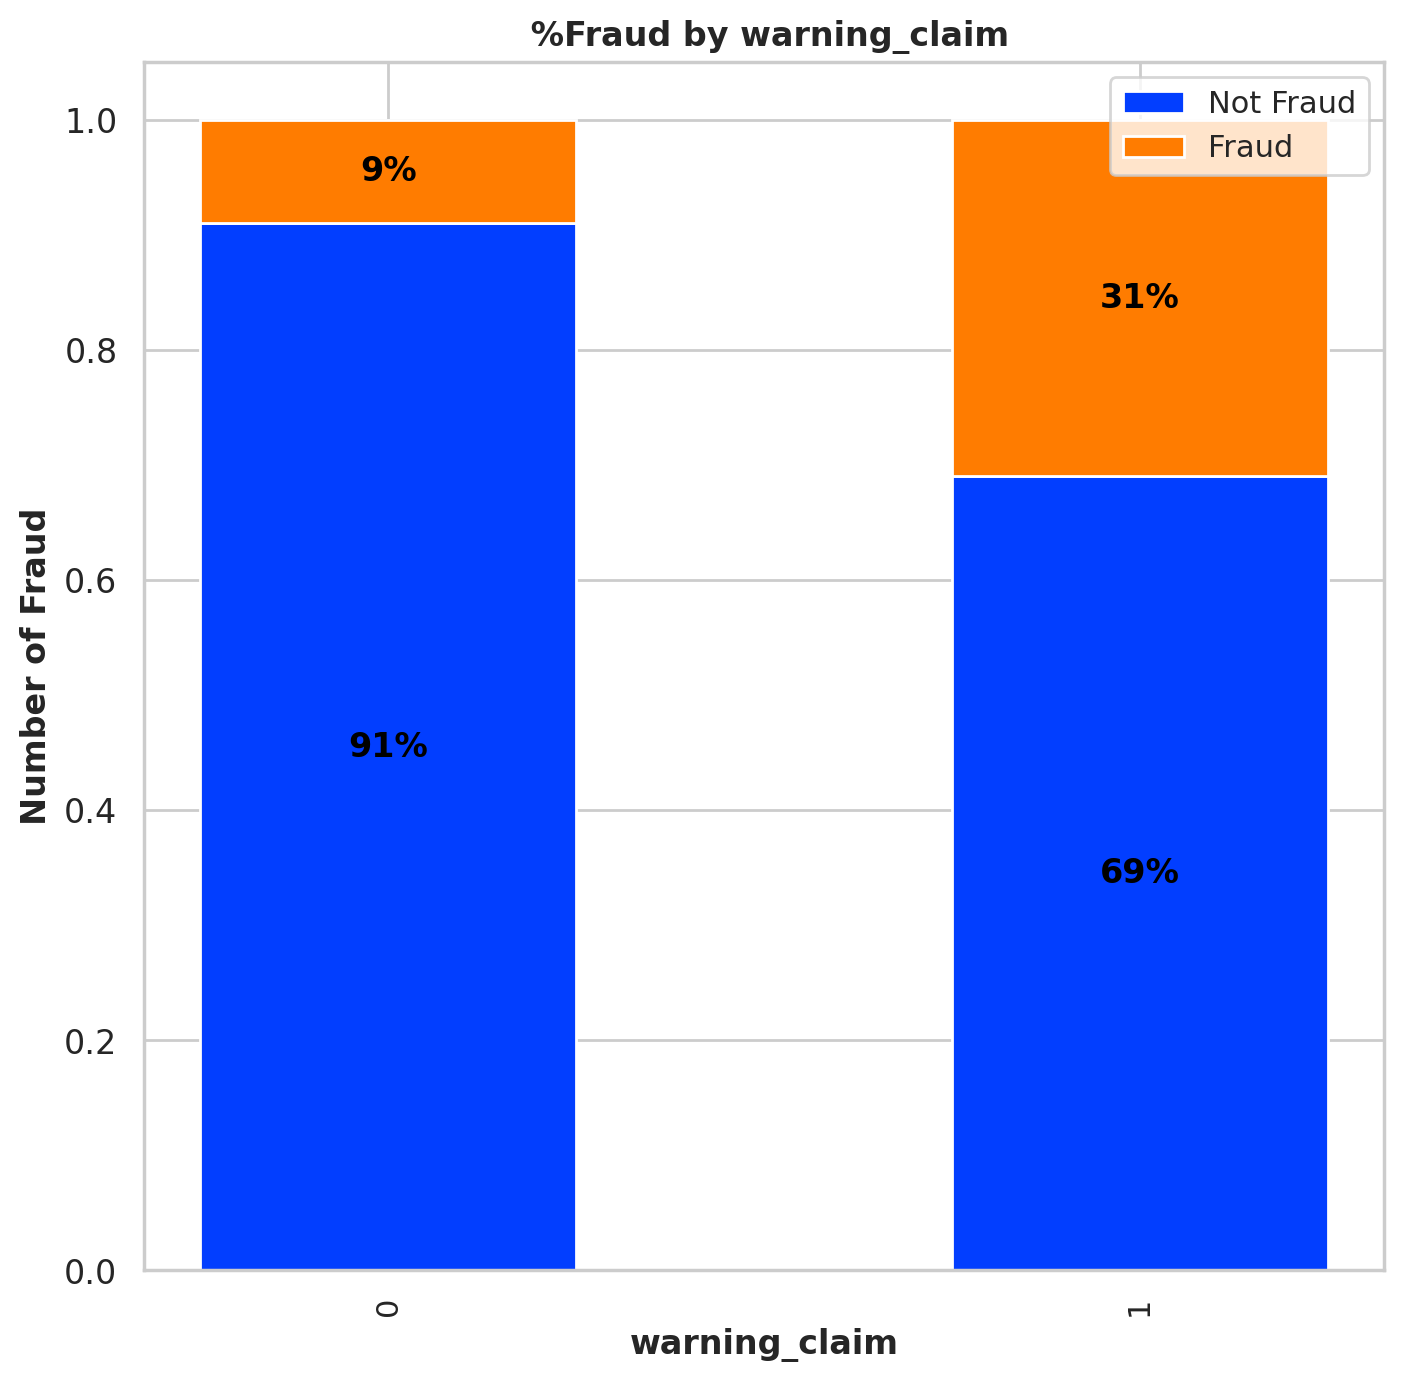

In [94]:
create_stacked_bar_percent(df_train,"warning_claim")

terjadi 31% fraud ketika total claim diatas 39000 dan vehicle diatas 25000 ribu

In [95]:
#Categorical Column Effect Size with Cramer's V

cramers = []
for i in df_train.select_dtypes(exclude = 'number').columns:
    cramers.append(cramers_v(df_train['fraud_reported'], df_train[i]))
res = pd.DataFrame(data = [df_train.select_dtypes(exclude = 'number').columns, cramers] 
             ).T 
res.columns = ['Column', 'Cramers_V']
res.sort_values(by = 'Cramers_V', ascending = False).reset_index(drop = True)

,Column,Cramers_V
0,incident_severity,0.556942
1,insured_hobbies,0.372676
2,collision_type,0.171598
3,incident_type,0.168875
4,authorities_contacted,0.158053
5,incident_state,0.134385
6,property_damage,0.083365
7,policy_csl,0.055306
8,insured_occupation,0.014137
9,insured_relationship,0.0


dilihat dari efek crammer, terlihat 4 kolom yang tidak memiliki kontribusi terhadap terjadinya fraud, yaitu kolom insured_relationship,insured_sex,insured_education_level,police_report_available sehingga kolom harus ditake out

In [96]:
df_train = df_train.drop(['insured_relationship','insured_sex','insured_education_level','police_report_available'],axis=1)
df_test = df_test.drop(['insured_relationship','insured_sex','insured_education_level','police_report_available'],axis=1)

#cat
cat = df_train.select_dtypes(include='object').columns
cat

Index(['policy_csl', 'insured_occupation', 'incident_type', 'insured_hobbies',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'property_damage'],
      dtype='object')

In [97]:
for x in cat:
  print(df_train.groupby(x).agg({"fraud_reported":[len,"sum","mean"]}))
  print()

           fraud_reported              
                      len sum      mean
policy_csl                             
100/300               259  68  0.262548
250/500               263  81  0.307985
500/1000              243  55  0.226337

                   fraud_reported              
                              len sum      mean
insured_occupation                             
adm-clerical                   41   7  0.170732
armed-forces                   51  13  0.254902
craft-repair                   60  17  0.283333
exec-managerial                63  24  0.380952
farming-fishing                42  13  0.309524
handlers-cleaners              38   8  0.210526
machine-op-inspct              71  18  0.253521
other-service                  51  10  0.196078
priv-house-serv                57  11  0.192982
prof-specialty                 65  15  0.230769
protective-serv                47  13  0.276596
sales                          61  16  0.262295
tech-support                   62  20  

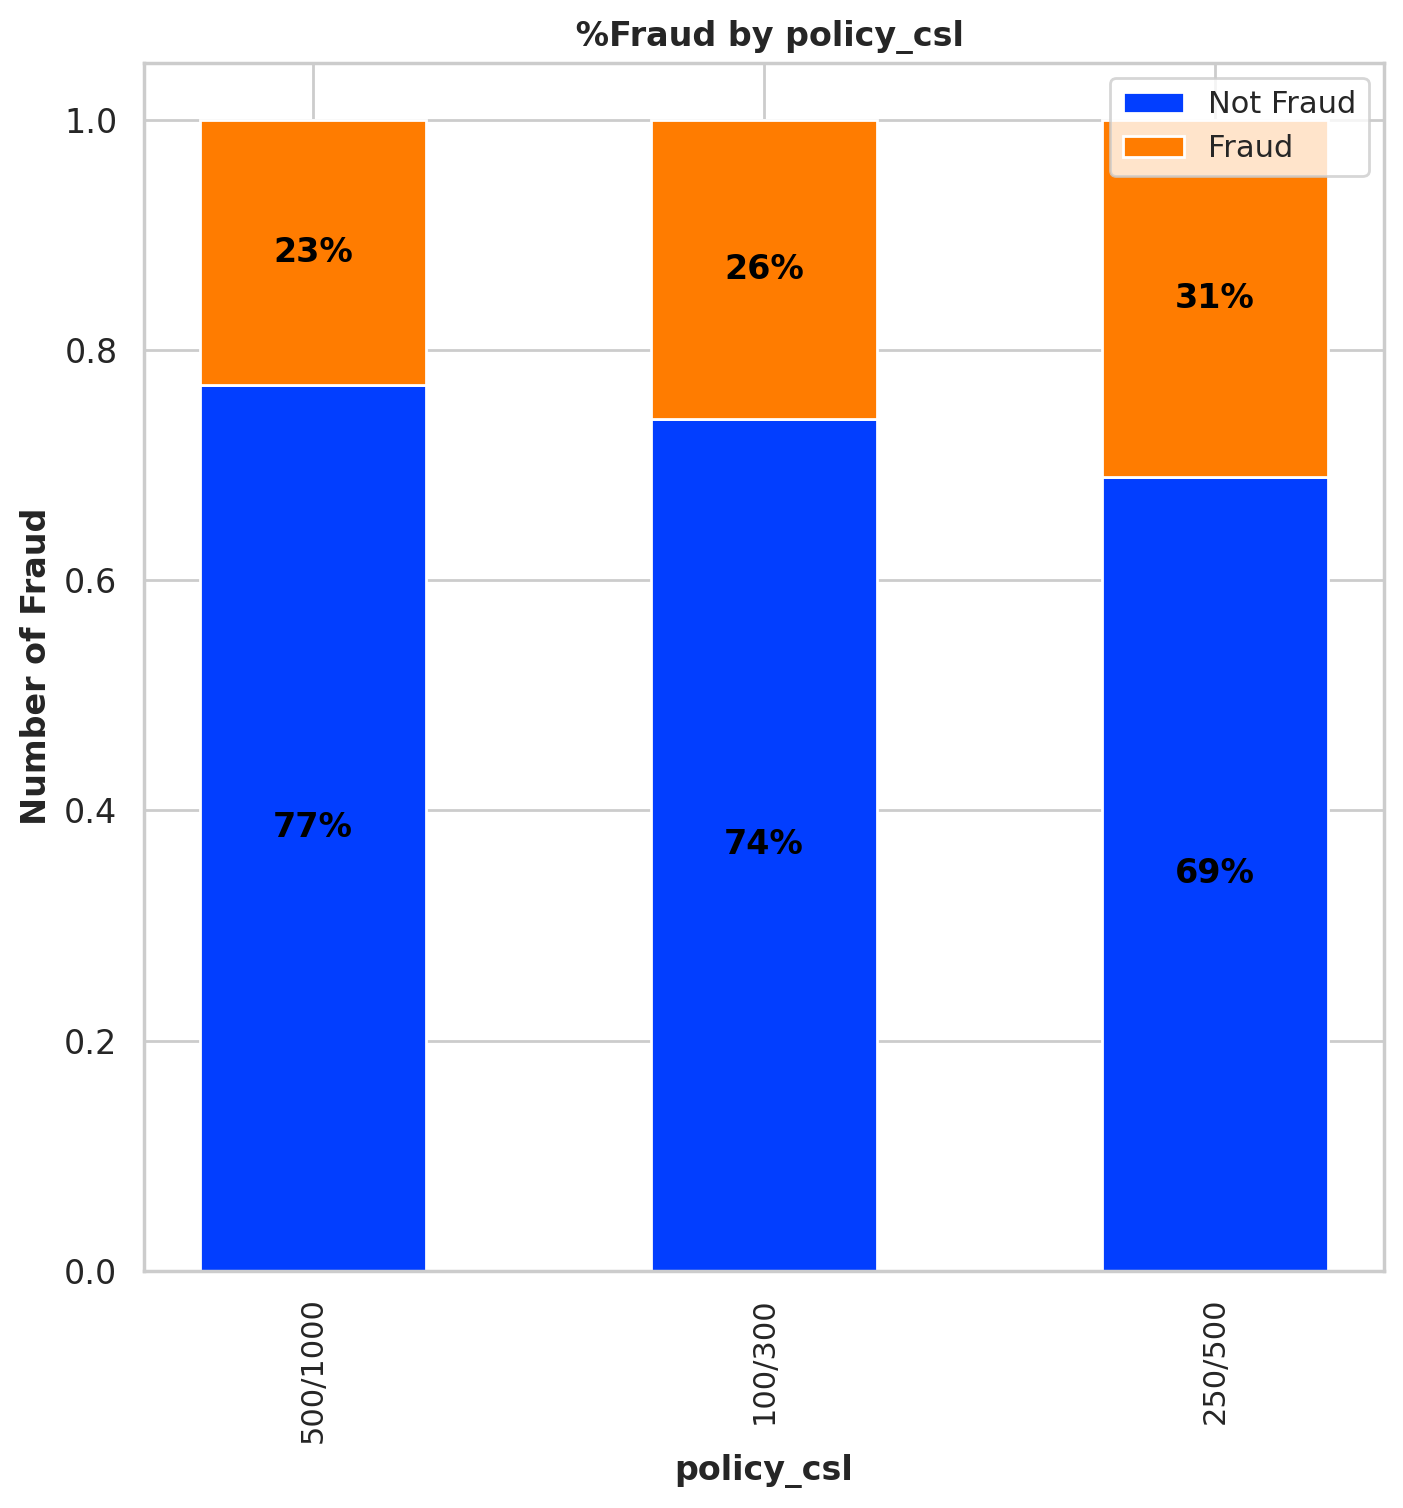

In [98]:
create_stacked_bar_percent(df_train,"policy_csl")

31% fraud terjadi ketika policy_csl bernilai 250/500. dari sini akan dibuat ranking berdasarkan persentase fraud yang terjadi. <br>
1 = 500/1000 <br>
2 = 100/300 <br>
3 = 250/500

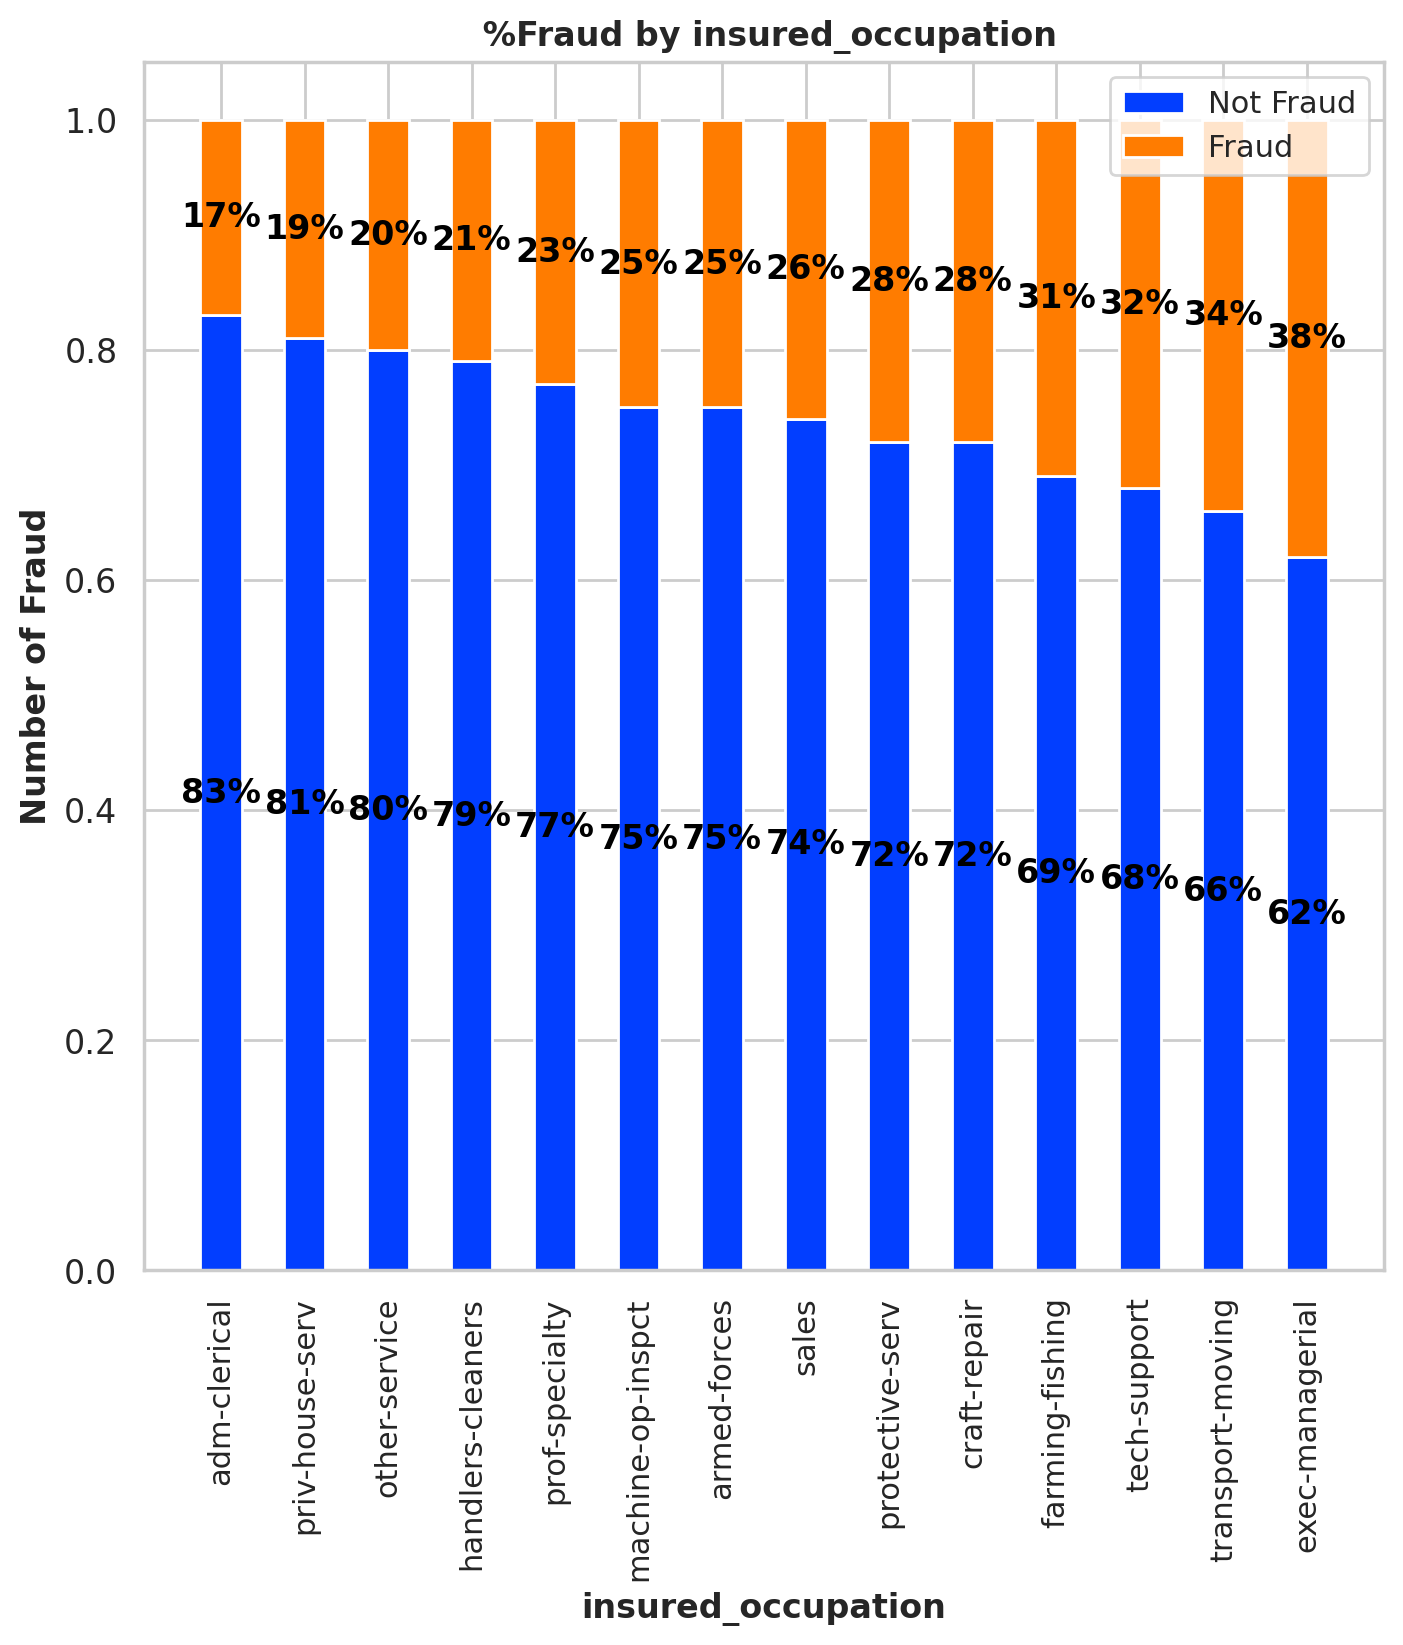

In [99]:
create_stacked_bar_percent(df_train,"insured_occupation")

tim perlu aware terhadap report dengan insured occputaion farming-finishing, tech-support, transport-support dan exec-managerial karena memiliki chance diatas 30% untuk terjadinya fraud

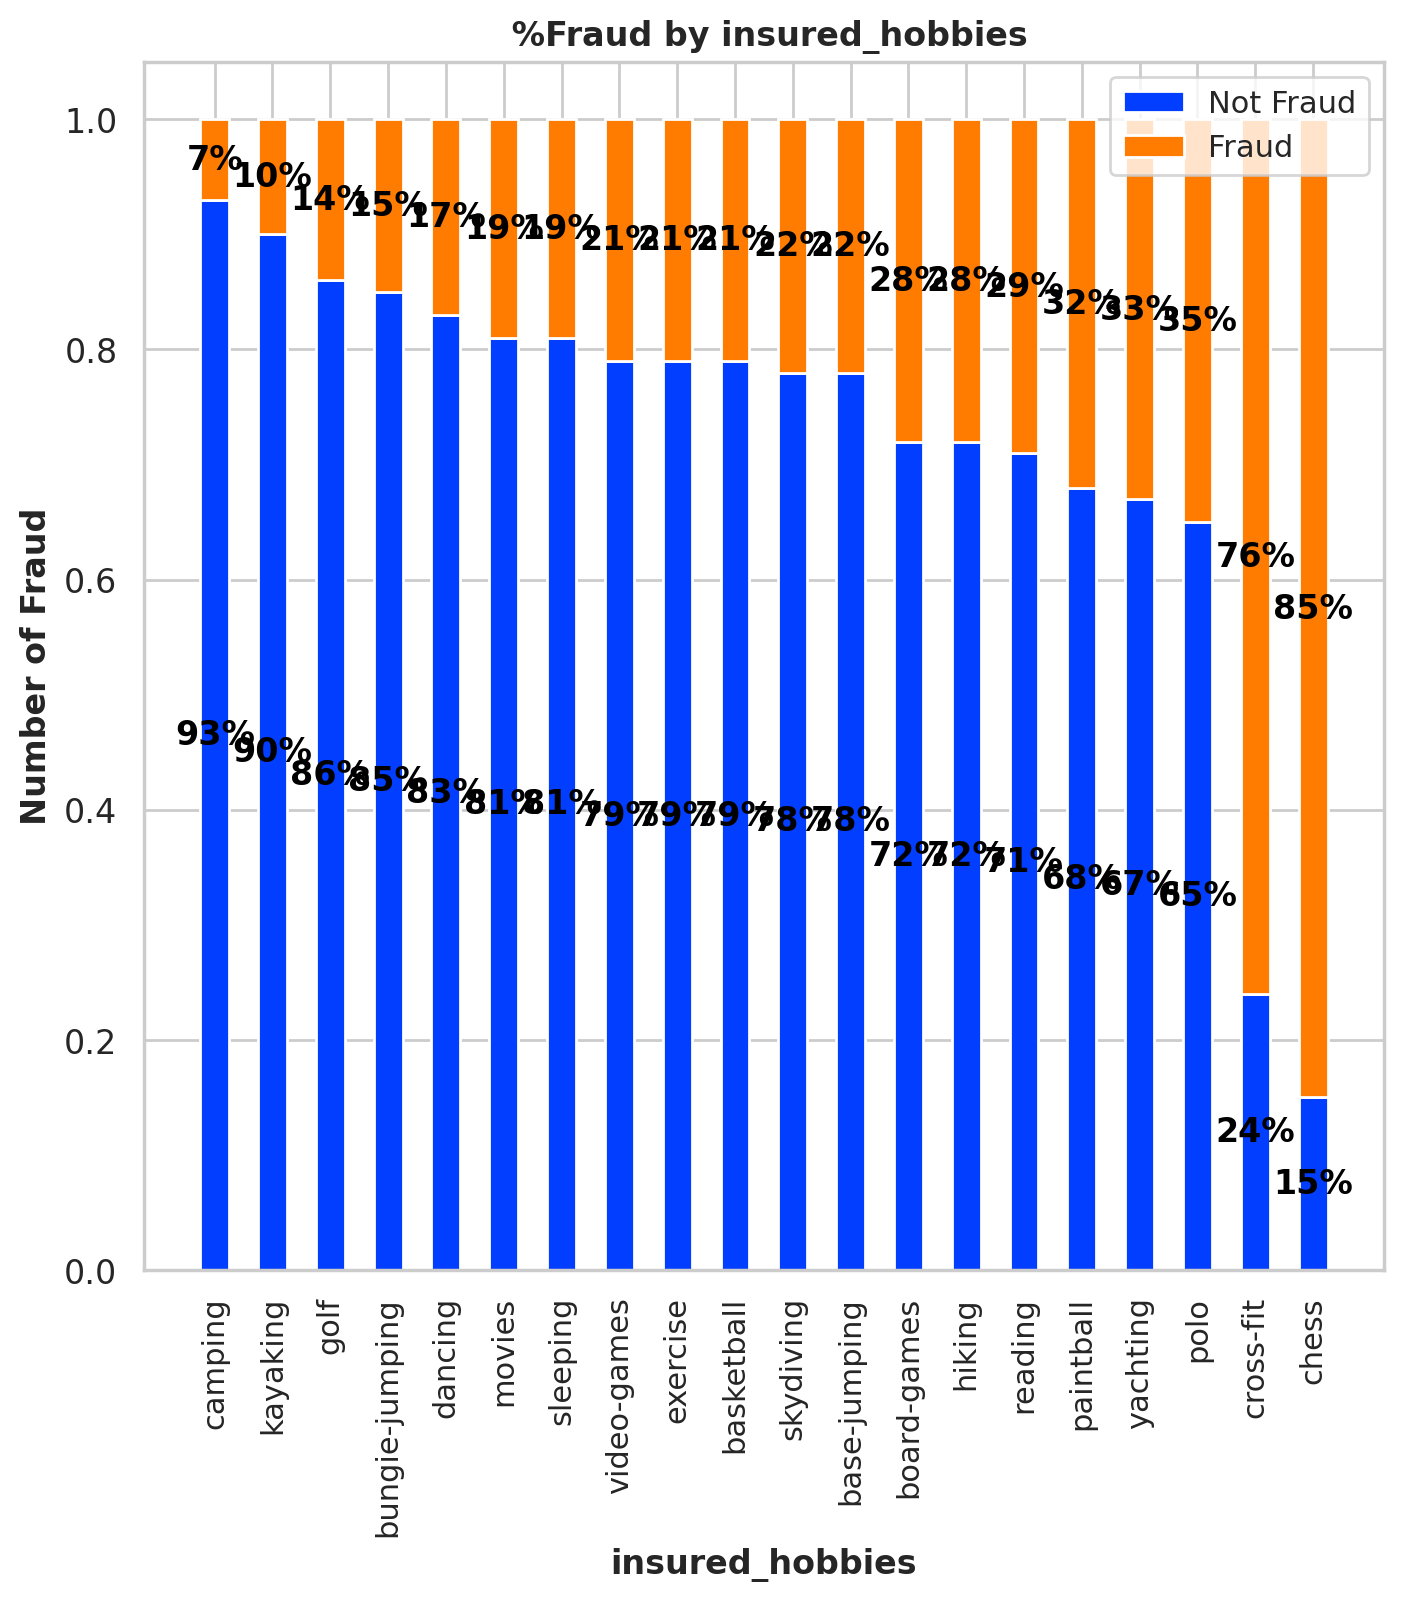

In [100]:
create_stacked_bar_percent(df_train,"insured_hobbies")

ternyata orang yang memiliki hobby cross-fit dan chess memiliki percentase fraud yang sangat tinggi sebesar 76% dan 85%

In [101]:
cat

Index(['policy_csl', 'insured_occupation', 'incident_type', 'insured_hobbies',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'property_damage'],
      dtype='object')

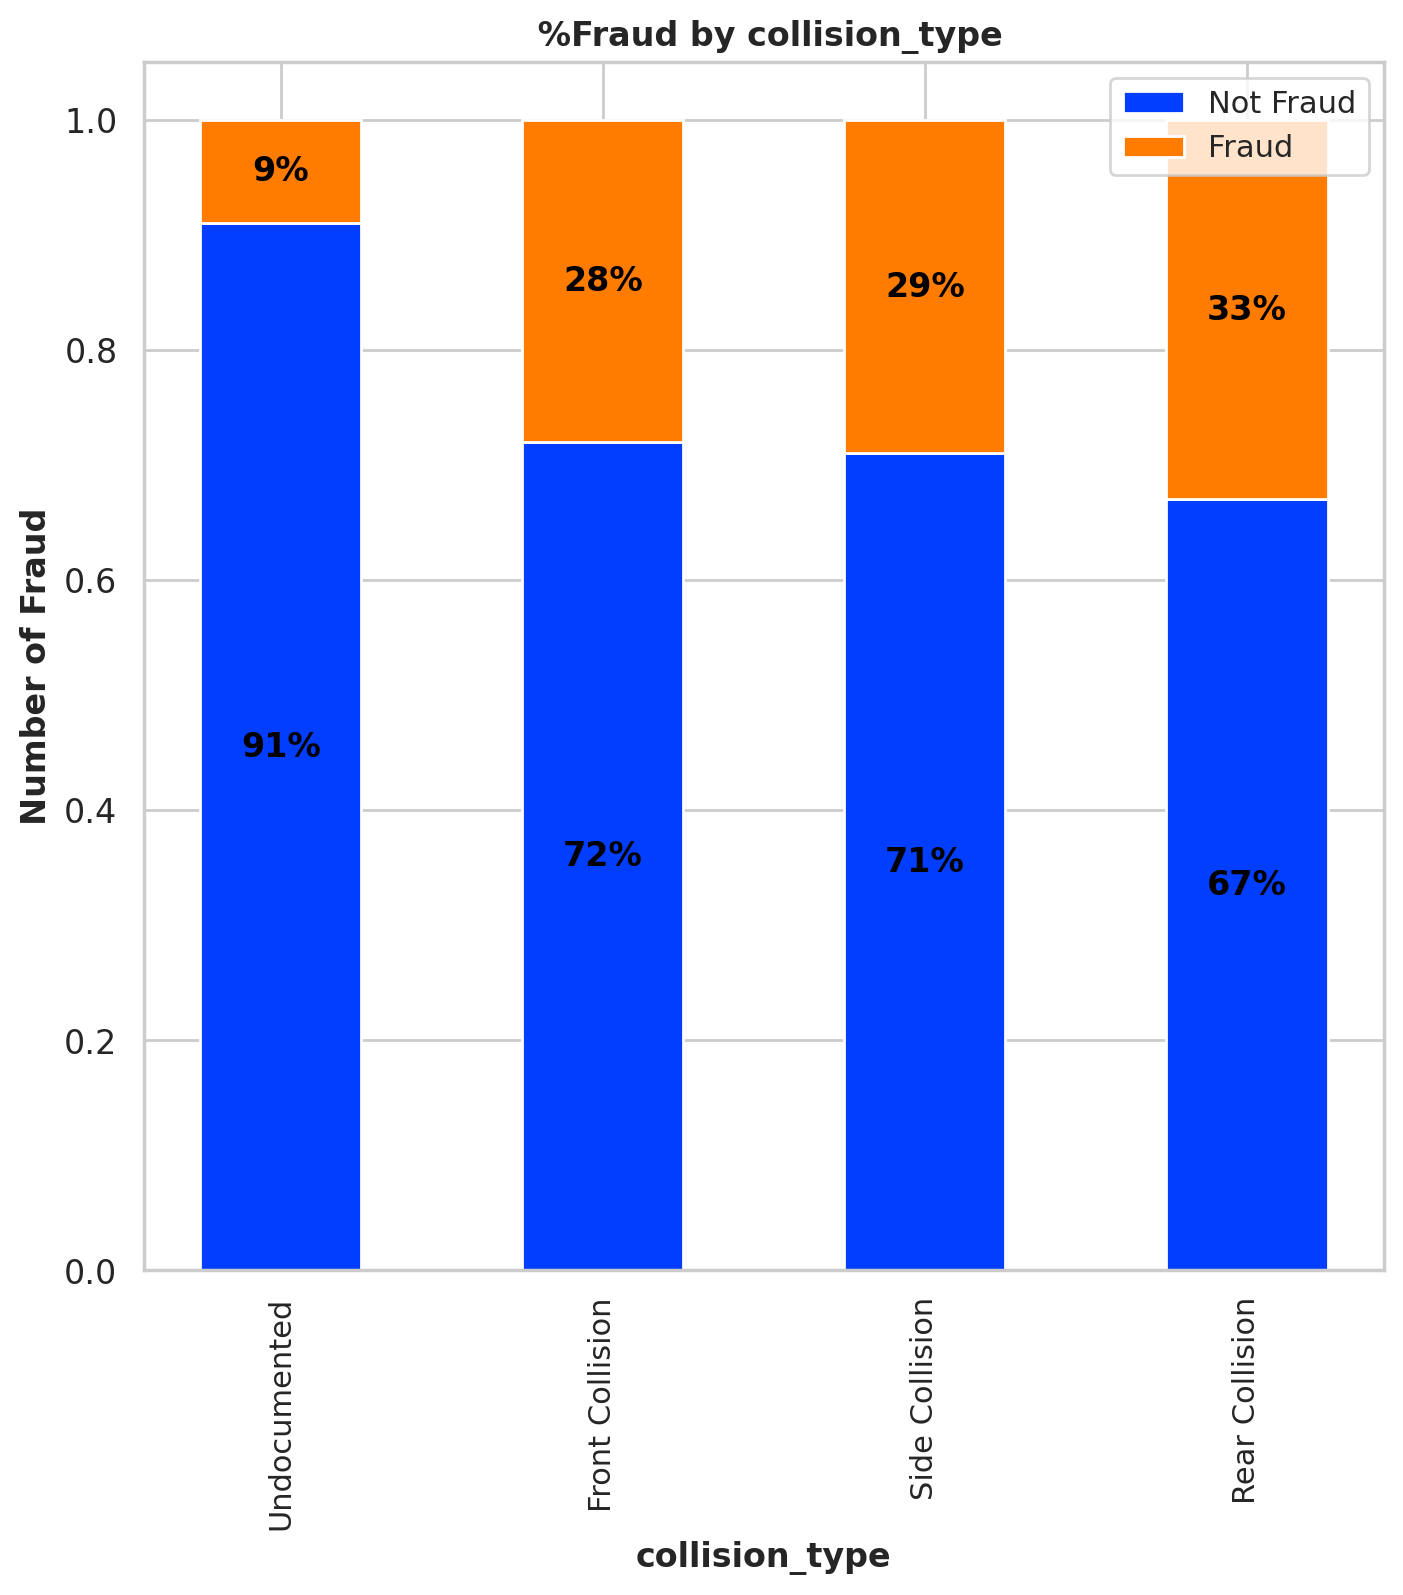

In [102]:
create_stacked_bar_percent(df_train,"collision_type")

jenis kecelakan yang tidak diketahui memiliki persentasi fraud terendah sedangkan dengan jenik kecelakaan rear collision memiliki persentase fraud sebesar 33%, untuk front dan side collision memiliki perbedaan yang sedikit sehingga dapat di kelompokkan menjadi jadi dan selanjutnya akan di ranking. <br>
0   = Unknown <br>
1  = Front dan Side Collision <br>
2  = Read Collision

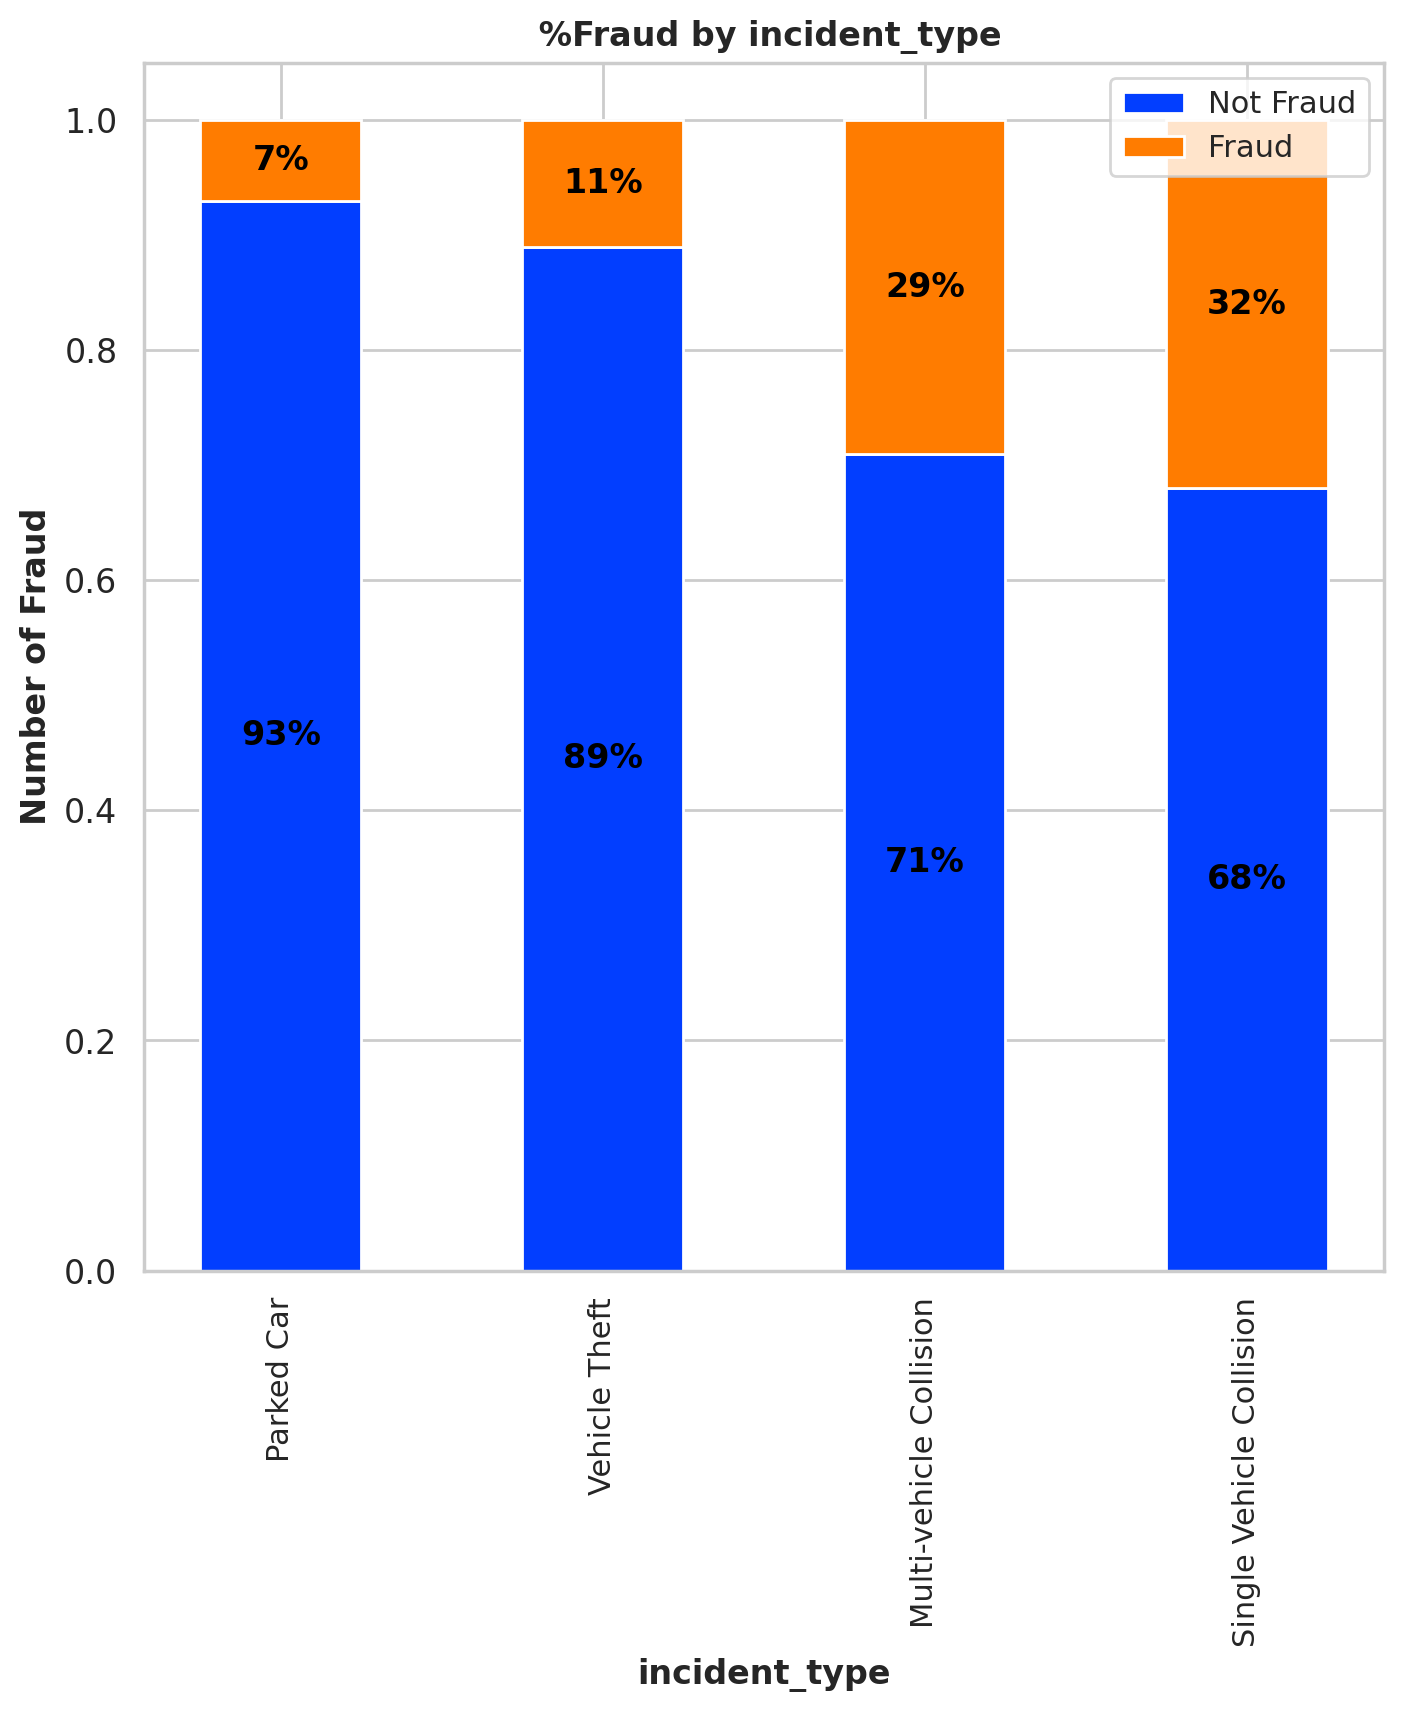

In [103]:
create_stacked_bar_percent(df_train,"incident_type")

berdasarkan dari jenis insiden, Multi dan Single Vehicle Collision memiliki 
persentase yag besar untuk terjadinya fraud

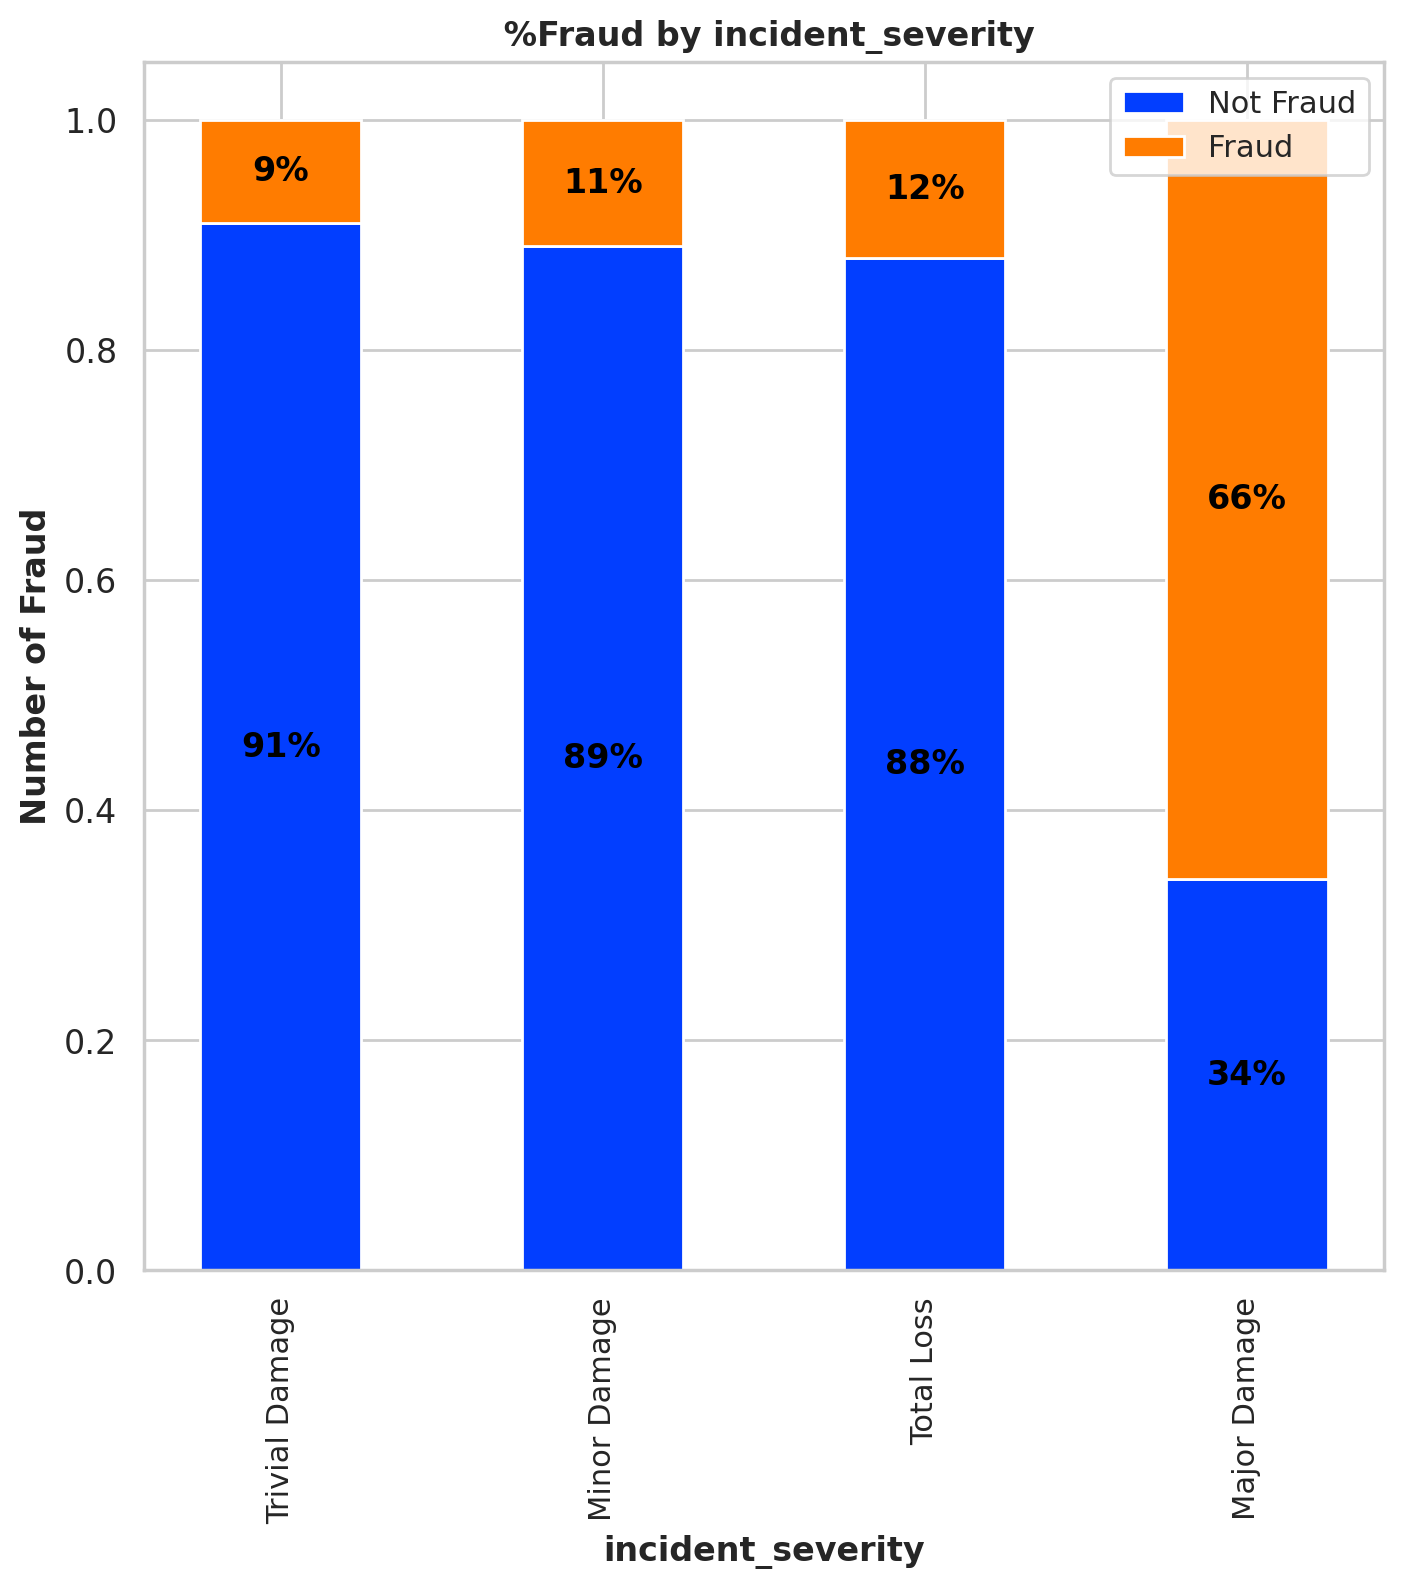

In [104]:
create_stacked_bar_percent(df_train,"incident_severity")

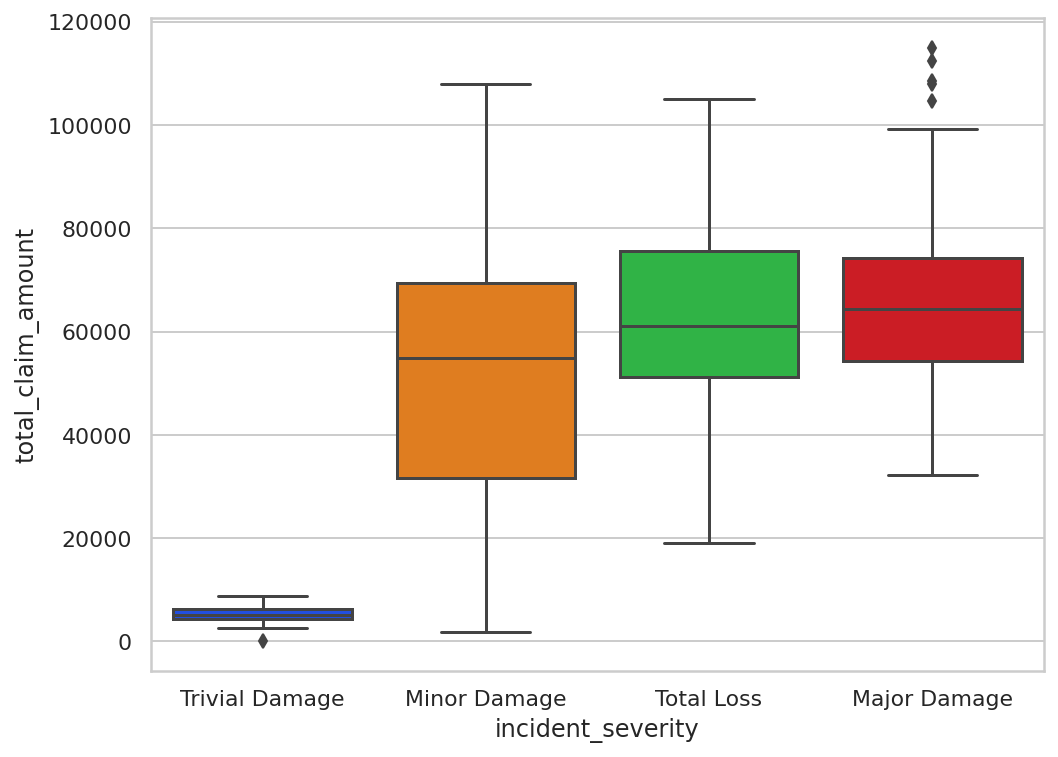

In [105]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_train,x="incident_severity",y="total_claim_amount",order=["Trivial Damage","Minor Damage","Total Loss","Major Damage"])

berdasarkan tingkat keparahannya, major damage memiliki persentase terbesar terjadinya fraud, masuk akal karena semakin tinggi tingkat keparahanya makin besar juga total claim yang akan diterima

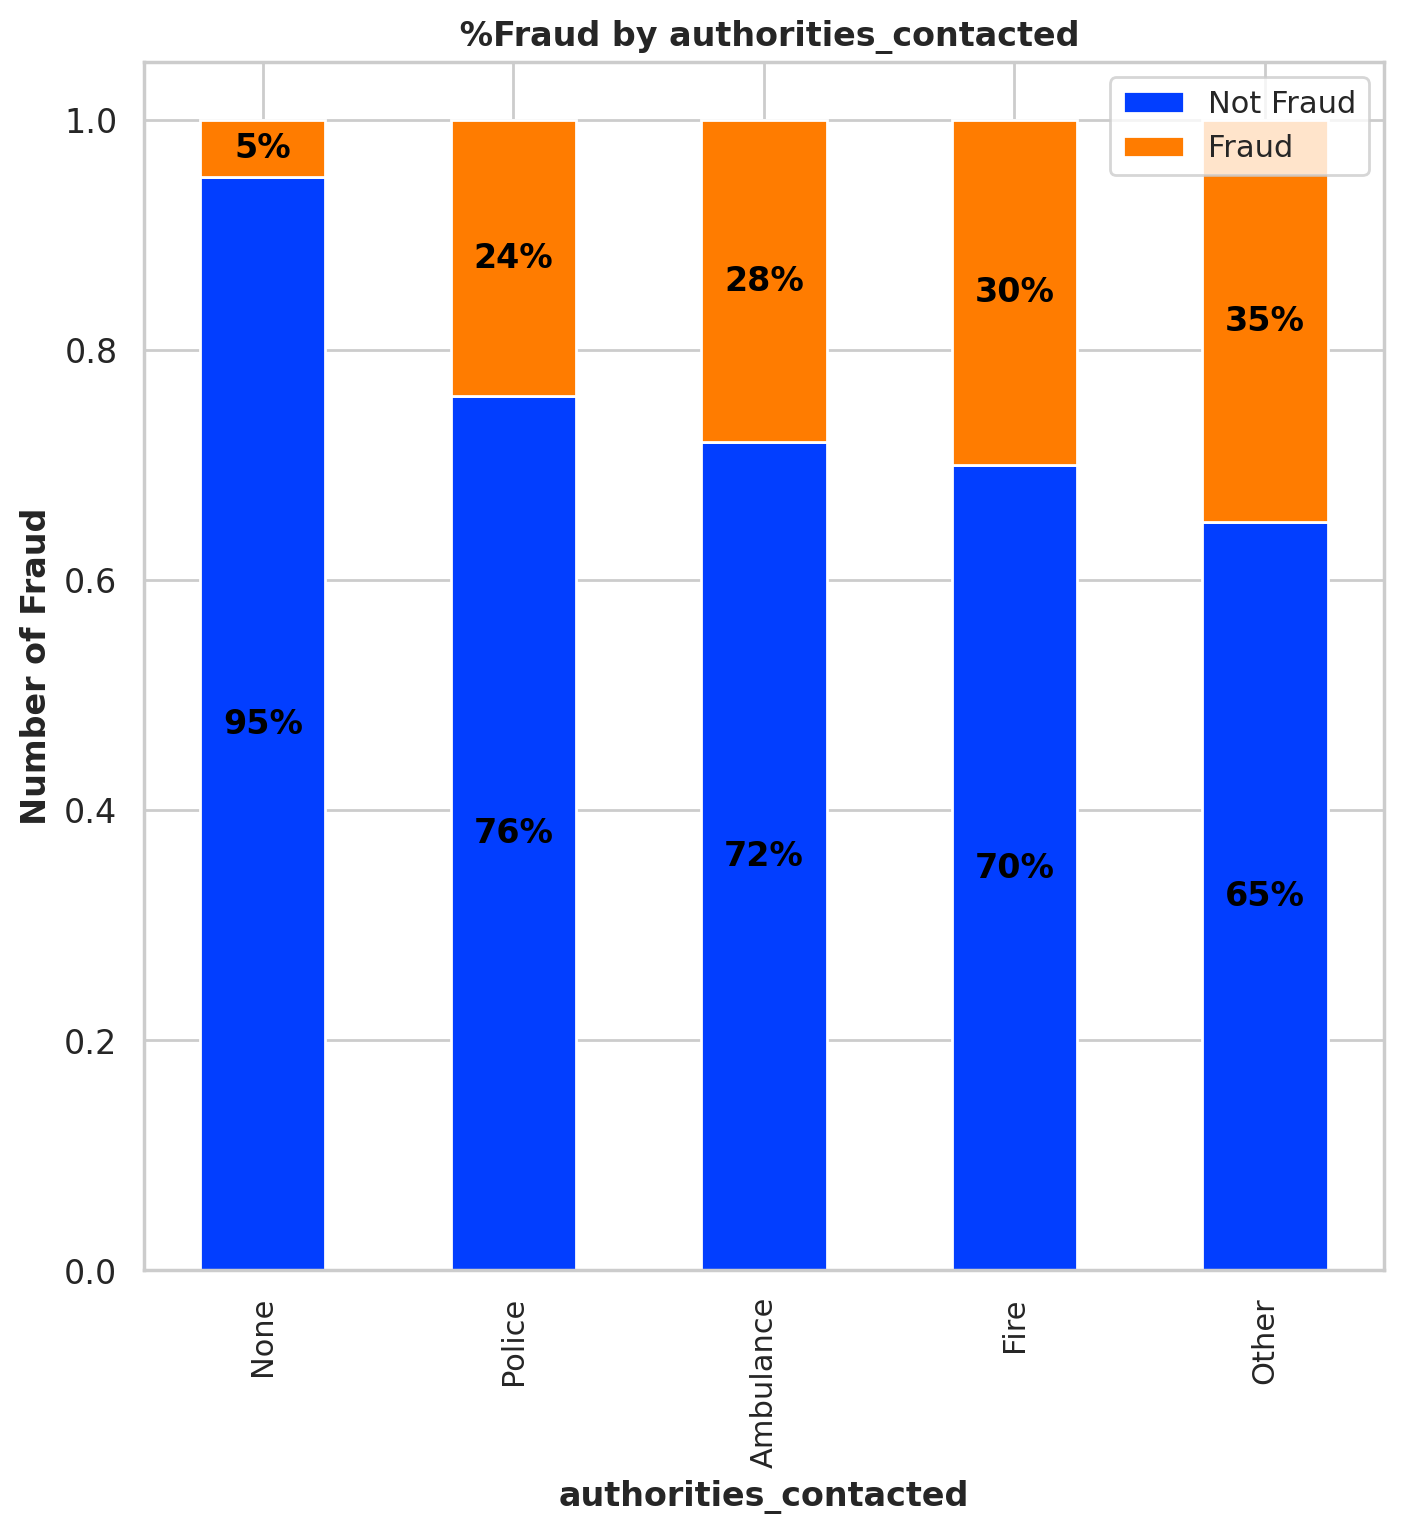

In [106]:
create_stacked_bar_percent(df_train,"authorities_contacted")

ketika tidak terdapat contak untuk dihubungin persentase fraud sangat kecil, sedangkan jenis kontak **fire** memiliki persentase yang tinggi. untuk **other** cukup bias karena Other tidak terdapat infomrasi yang jelas tentang other

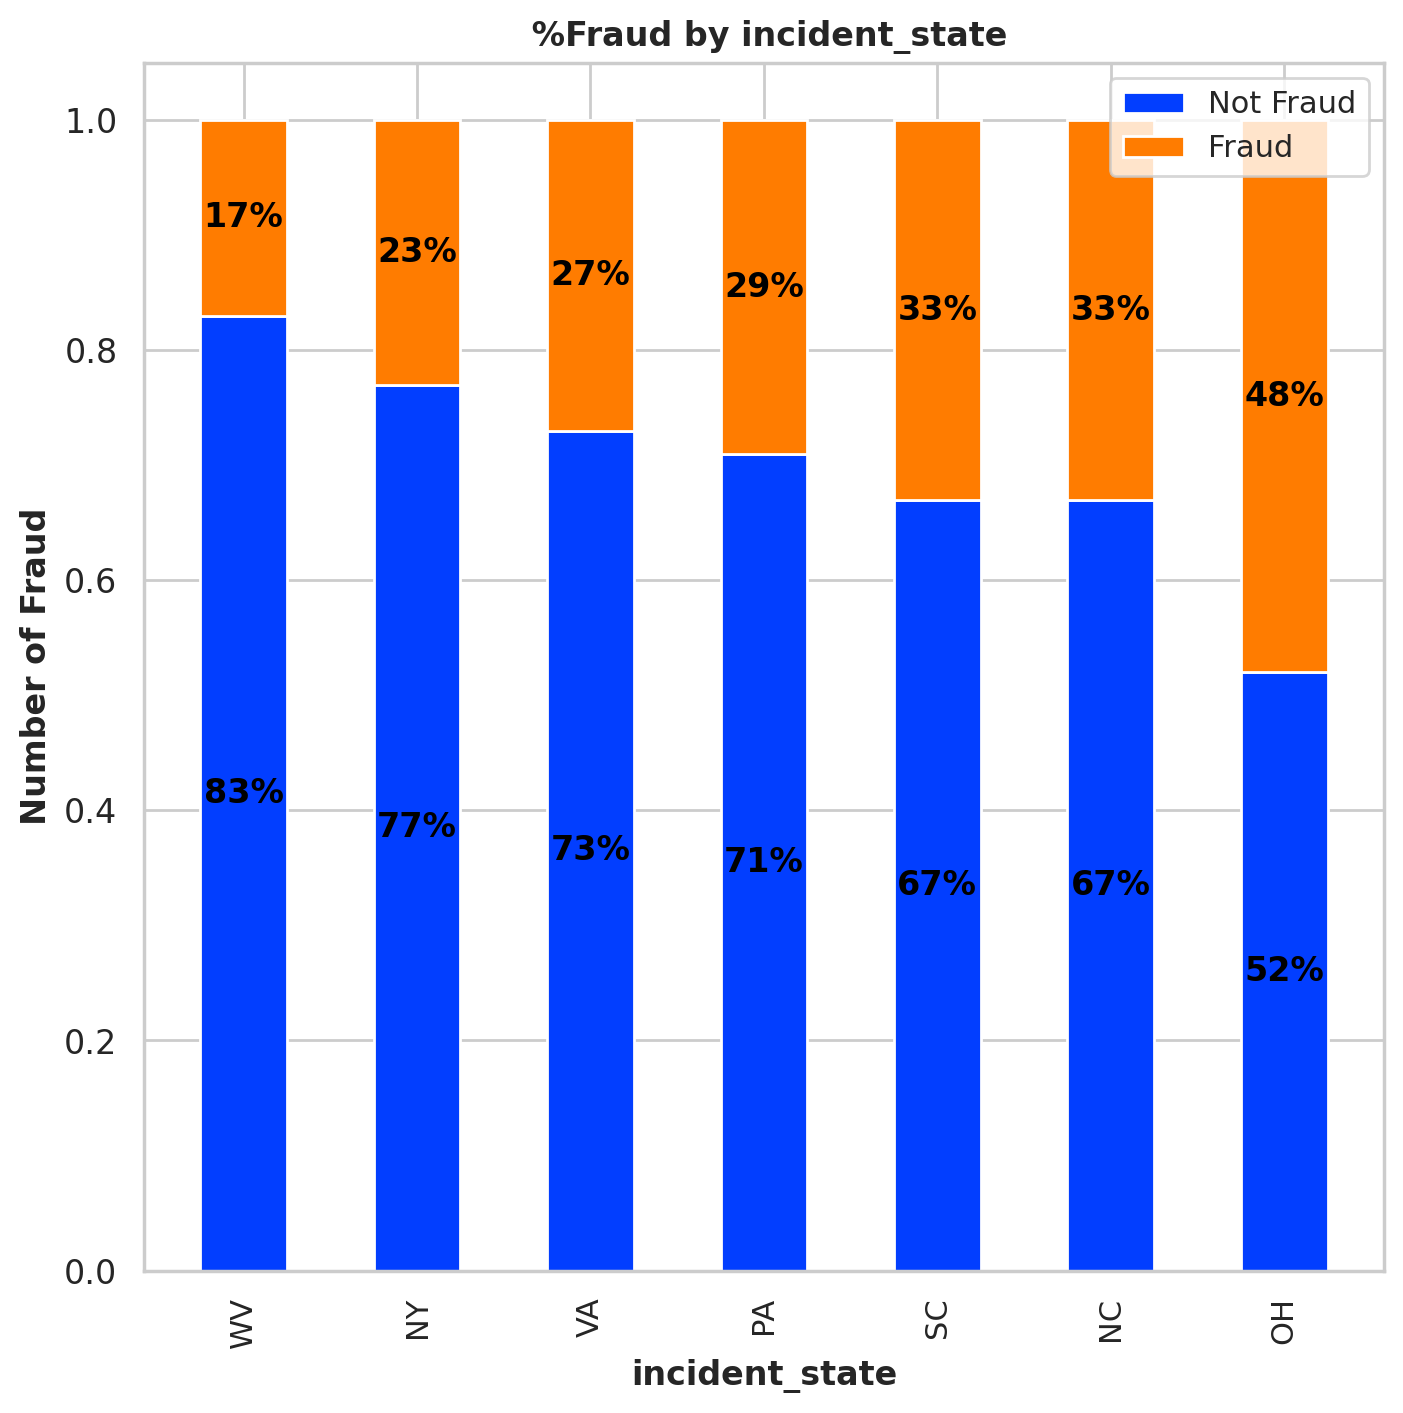

In [107]:
create_stacked_bar_percent(df_train,"incident_state")

jadi negara yang sering fraud adalah OH dengan persentase 48%, masuk akal karena OH adalah negara dengan tingkat kriminalitas yang tinggi, jadi tingkat kecurangan yang terjadi juga bisa tinggi

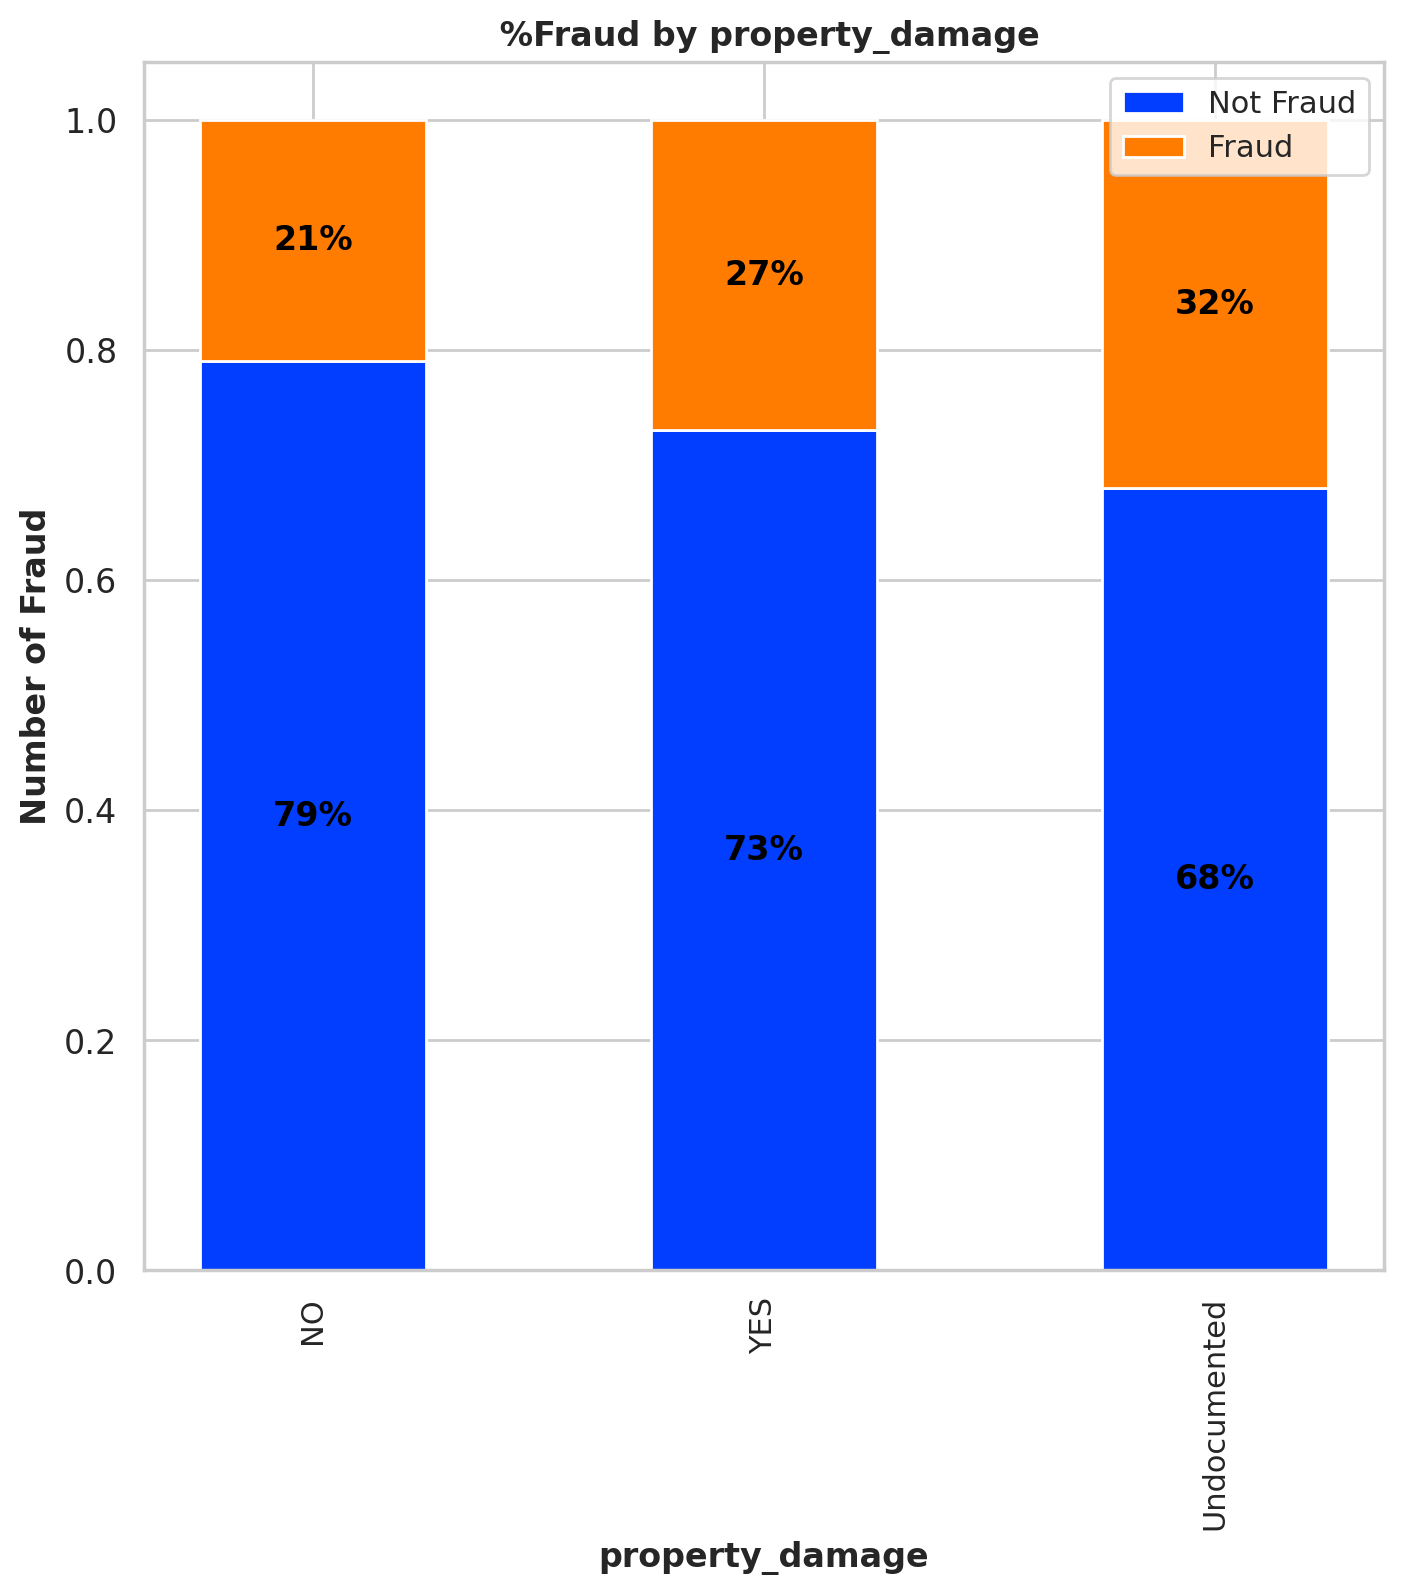

In [108]:
create_stacked_bar_percent(df_train,"property_damage")

properti damage yang tidak diketahui memiliki persentase fraud yang besar dibandingkan dengan No dan Yes

# Question 4: Machine Learning Model

Buatlah model machine learning dengan regresi logistik dan KNN sebagai baseline dari model, lalu random forest dan XgBoost sebagai model lanjutan. Evaluasi model menggunakan metrik f1-score, precision, recall dan AUC. Gunakan metode G-means untuk mengatasi masalah imbalanced jika ada 
**(30 poin)**

In [109]:
#ordinal category
ord_policy_csl = {'500/1000':1,
                 '100/300':2,
                  '250/500':3}

properti_damage = {"NO":0,
                   "YES":1,
                   "UNKNOWN":2}

incident_type = {"Parked Car":0,
                 "Vehicle Theft":1,
                 "Multi-vehicle Collision":2,
                 "Single Vehicle Collision":3}

collision_type = {"UNKNOWN":0,
                  "Front Collision":1,
                  "Side Collision":1,
                  "Rear Collision":2}

incident_severity = {"Trivial Damage":1,
                     "Minor Damage":2,
                     "Total Loss":3,
                     "Major Damage":4}

df_train["policy_csl"] = df_train["policy_csl"].map(ord_policy_csl)
df_train['incident_severity'] = df_train['incident_severity'].map(incident_severity)
df_train["property_damage"] = df_train["property_damage"].map(properti_damage)
df_train["incident_type"] = df_train["incident_type"].map(incident_type)
df_train["collision_type"] = df_train["collision_type"].map(collision_type)


df_test["policy_csl"] = df_test["policy_csl"].map(ord_policy_csl)
df_test['incident_severity'] = df_test['incident_severity'].map(incident_severity)
df_test["property_damage"] = df_test["property_damage"].map(properti_damage)
df_test["incident_type"] = df_test["incident_type"].map(incident_type)
df_test["collision_type"] = df_test["collision_type"].map(collision_type)

#nominal cat
cat_nom_col =["insured_occupation","insured_hobbies","authorities_contacted","incident_state"]

#for training
dummies = pd.DataFrame()
for x in cat_nom_col:
  dummies = pd.get_dummies(df_train[x],prefix=x+"_")
  df_train = pd.concat([df_train,dummies],axis=1)

#for testing
dummies_1 = pd.DataFrame()
for x in cat_nom_col:
  dummies_1 = pd.get_dummies(df_test[x],prefix=x+"_")
  df_test = pd.concat([df_test,dummies_1],axis=1)

#drop col
df_train = df_train.drop(cat_nom_col,axis=1)
df_test = df_test.drop(cat_nom_col,axis=1)

In [110]:
#untuk mengindari terjadinya perfect multicolinearity maka kolom yang di dummies akan dibuang salah satunya
df_train = df_train.drop(["insured_occupation__adm-clerical","insured_hobbies__camping","authorities_contacted__None","incident_state__WV"],axis=1)
df_test = df_test.drop(["insured_occupation__adm-clerical","insured_hobbies__camping","authorities_contacted__None","incident_state__WV"],axis=1)

In [111]:
df_train.head()

,policy_csl,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_type,collision_type,incident_severity,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported,warning_claim,insured_occupation__armed-forces,insured_occupation__craft-repair,insured_occupation__exec-managerial,insured_occupation__farming-fishing,insured_occupation__handlers-cleaners,insured_occupation__machine-op-inspct,insured_occupation__other-service,insured_occupation__priv-house-serv,insured_occupation__prof-specialty,insured_occupation__protective-serv,insured_occupation__sales,insured_occupation__tech-support,insured_occupation__transport-moving,insured_hobbies__base-jumping,insured_hobbies__basketball,insured_hobbies__board-games,insured_hobbies__bungie-jumping,insured_hobbies__chess,insured_hobbies__cross-fit,insured_hobbies__dancing,insured_hobbies__exercise,insured_hobbies__golf,insured_hobbies__hiking,insured_hobbies__kayaking,insured_hobbies__movies,insured_hobbies__paintball,insured_hobbies__polo,insured_hobbies__reading,insured_hobbies__skydiving,insured_hobbies__sleeping,insured_hobbies__video-games,insured_hobbies__yachting,authorities_contacted__Ambulance,authorities_contacted__Fire,authorities_contacted__Other,authorities_contacted__Police,incident_state__NC,incident_state__NY,incident_state__OH,incident_state__PA,incident_state__SC,incident_state__VA
policy_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
521585,3,1406.91,0,53300,0,3,1.0,4,1,1.0,1,2,71610,6510,13020,52080,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
342868,3,1197.22,5000000,0,0,1,NaN,2,1,NaN,0,0,5070,780,780,3510,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
227811,3,1415.74,6000000,48900,-62400,3,1.0,4,1,NaN,1,2,63400,6340,6340,50720,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
104594,3,1351.10,0,0,0,2,2.0,4,3,0.0,0,2,64100,6410,6410,51280,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
413978,3,1333.35,0,0,-77000,2,1.0,2,3,NaN,0,0,78650,21450,7150,50050,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


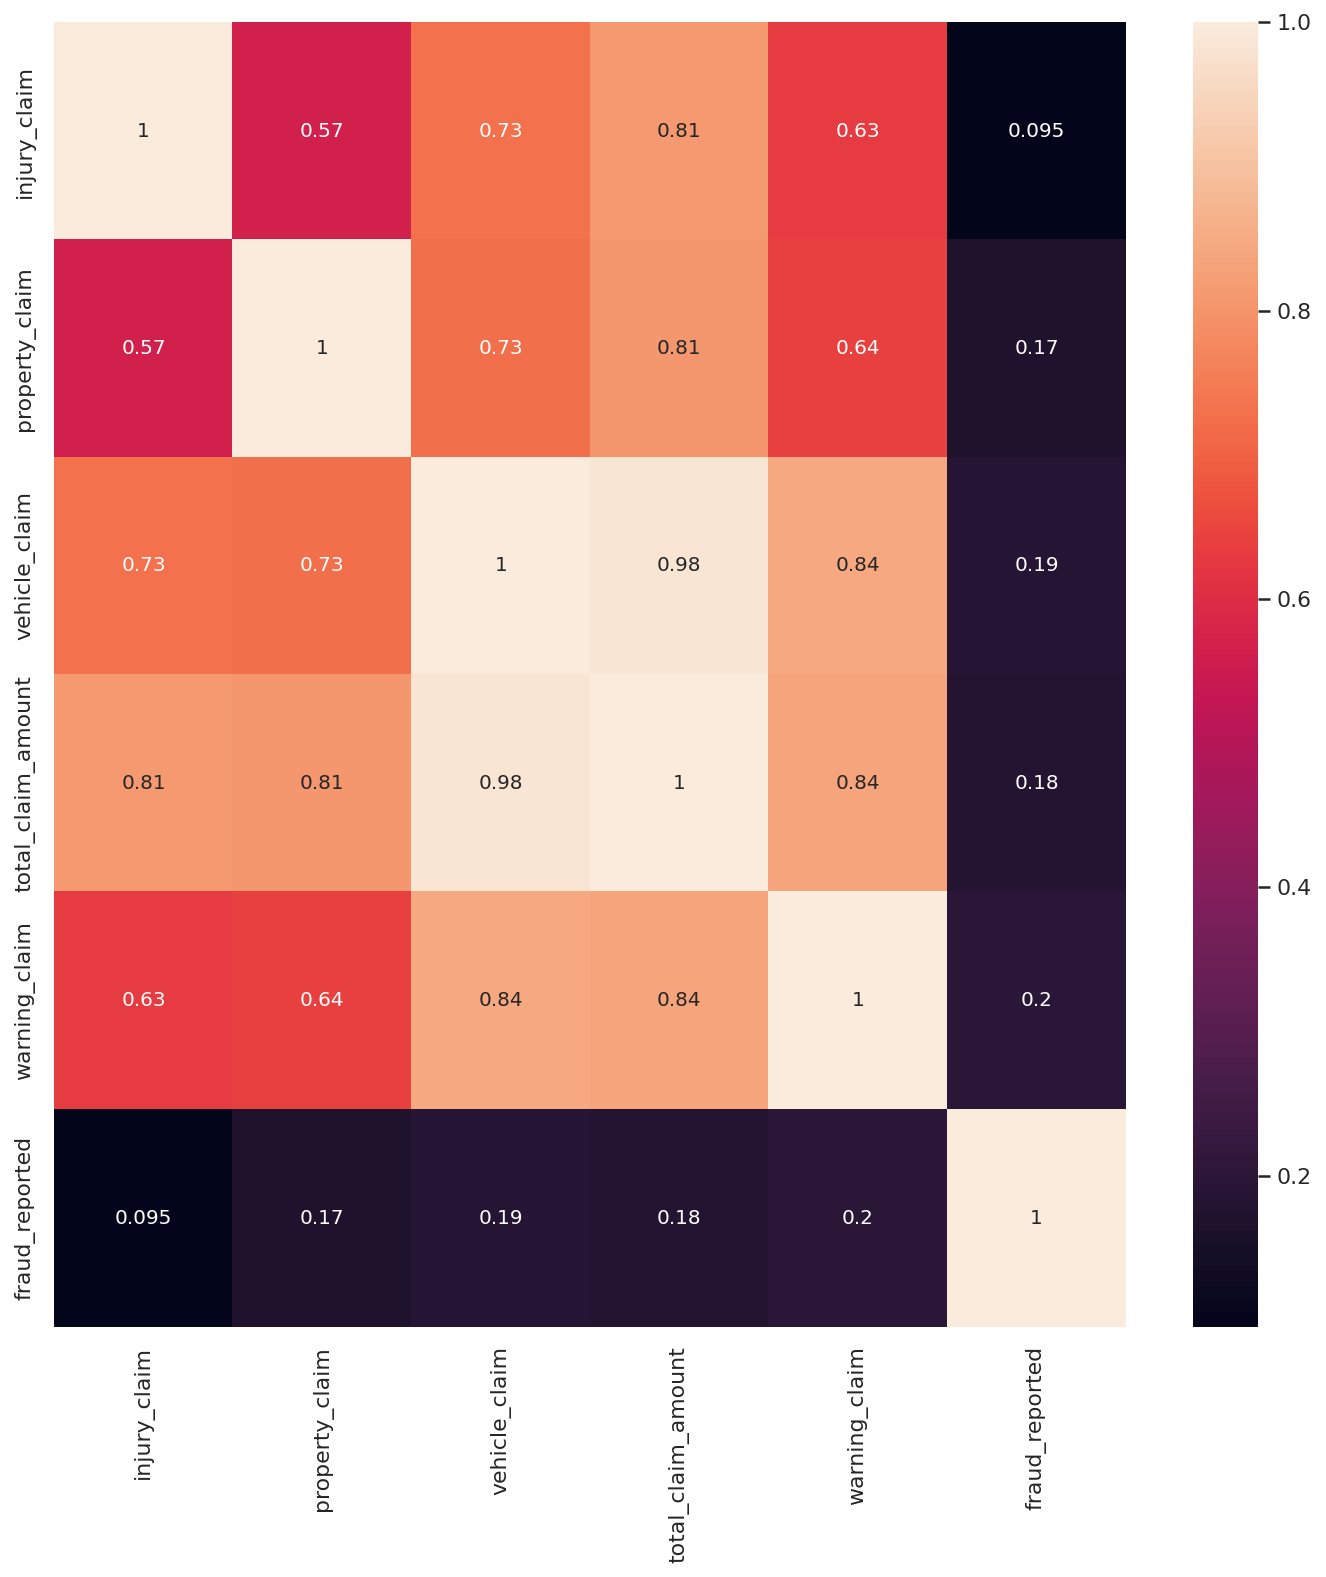

In [112]:
#check multicolineairy untuk claim
plt.figure(figsize=(12,12))
sns.heatmap(df_train[["injury_claim","property_claim","vehicle_claim","total_claim_amount","warning_claim","fraud_reported"]].corr(),annot=True,fmt='.2g')

kolinearitas tinggi terjadi pada vehicle dan total amount, disini akan dibuang total amaoun, karena total amount adalah jumlah dari injury_claim,property_claim dan vehicle_claim

In [120]:
df_train = df_train.drop("total_claim_amount",axis=1)
df_test = df_test.drop("total_claim_amount",axis=1)

KeyError: ignored

In [117]:
#check multicolineairy untuk claim
plt.figure(figsize=(25,25))
sns.heatmap(df_train.corr(),annot=True,fmt='.2g')

## Logistic Regression

In [115]:
X_train = df_train.drop("fraud_reported",axis=1).copy()
y_train = df_train["fraud_reported"].copy()

X_test = df_test.drop("fraud_reported",axis=1).copy()
y_test = df_test["fraud_reported"].copy()

In [116]:
#=====Logistic regression======
logreg = LogisticRegression()

#params
random_grid = {"penalty":["elasticnet","l2"],
       "fit_intercept":[True,False],
       "C": [0.25, 0.5, 0.75, 1.0]}

scoreFunction = {"f1": "f1"}
random_search = RandomizedSearchCV(logreg,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV')

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_train, random_search.best_estimator_.predict(X_train))
print(metrics.classification_report(y_train,random_search.best_estimator_.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix Logreg Training')

plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search.best_estimator_.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search.best_estimator_.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logreg on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logreg Forest on val data: ', round(gini_value*100, 2), '%')

In [ ]:
# predict test
cnf_matrix = metrics.confusion_matrix(y_test, random_search.best_estimator_.predict(X_test))
print(metrics.classification_report(y_test,random_search.best_estimator_.predict(X_test)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix Logreg Test')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search.best_estimator_.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Logreg  on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Logreg  on val data: ', round(gini_value*100, 2), '%')

## KNN

In [ ]:
#======KNN====
knn = KNeighborsClassifier()

#params
random_grid = {"n_neighbors": [2,3,4,5],
       "p":[1,2]}

scoreFunction = {"f1": "f1"}
random_search = RandomizedSearchCV(knn,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV')

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_train, random_search.best_estimator_.predict(X_train))
print(metrics.classification_report(y_train,random_search.best_estimator_.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix KNN Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search.best_estimator_.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search.best_estimator_.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for KNN on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for KNN  on val data: ', round(gini_value*100, 2), '%')

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_test, random_search.best_estimator_.predict(X_test))
print(metrics.classification_report(y_test,random_search.best_estimator_.predict(X_test)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix KNN Test')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search.best_estimator_.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for KNN  on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for KNN  on val data: ', round(gini_value*100, 2), '%')

## Random Forest

In [ ]:
#=====Random Forest======
rf = RandomForestClassifier()

random_grid = {'n_estimators': [10, 50, 100, 1000],
               'max_features': ["sqrt", "log2"],
               'max_depth': [3,5,10, None],
               'criterion':['gini','entropy']}

scoreFunction = {"f1": "f1"}

random_search = RandomizedSearchCV(rf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV ')

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_train, random_search.best_estimator_.predict(X_train))
print(metrics.classification_report(y_train,random_search.best_estimator_.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix Random Forest Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search.best_estimator_.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search.best_estimator_.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Random Forest on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Random Forest on val data: ', round(gini_value*100, 2), '%')

In [ ]:
# predict test
cnf_matrix = metrics.confusion_matrix(y_test, random_search.best_estimator_.predict(X_test))
print(metrics.classification_report(y_test,random_search.best_estimator_.predict(X_test)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix Random Forest Test')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search.best_estimator_.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for Random Forest on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for Random Forest  on val data: ', round(gini_value*100, 2), '%')

## XGBoost

In [ ]:
#=====XGBoost======
xgb = XGBClassifier()


random_grid = {'n_estimators': [10, 50, 100],
               "learning_rate": [0.1, 0.05, 0.01],
               'max_depth': [3,5,10],
               "grow_policy": ["depthwise", "lossguide"]}

scoreFunction = {"f1": "f1"}

random_search = RandomizedSearchCV(xgb,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train, y_train)

print('Finished RandomizedSearchCV ')

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_train, random_search.best_estimator_.predict(X_train))
print(metrics.classification_report(y_train,random_search.best_estimator_.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search.best_estimator_.predict_proba(X_train)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search.best_estimator_.predict_proba(X_train)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for XGBOOST on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGBOOST Forest on val data: ', round(gini_value*100, 2), '%')

In [ ]:
# predict test
cnf_matrix = metrics.confusion_matrix(y_test, random_search.best_estimator_.predict(X_test))
print(metrics.classification_report(y_test,random_search.best_estimator_.predict(X_test)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Test')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search.best_estimator_.predict_proba(X_test)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for XGBOOST  on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGBOOST  on val data: ', round(gini_value*100, 2), '%')

Hasil evaluasi terbaik adalah  XGBOOST dengan score F-1 score dan ROC

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(true_positive_rate * (1 - false_positive_rate))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(threshold[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(false_positive_rate[index], ndigits = 4)
tprOpt = round(true_positive_rate[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

In [ ]:
thrshold = 0.4587000012397766
y_pred_thr = np.where(random_search.predict_proba(X_test)[:,1]>=thrshold,1,0)
# predict test
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_thr)
print(metrics.classification_report(y_test,y_pred_thr))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Test')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

# Question 5: Model Interpretation

Interpretasikan model terbaik (berdasarkan f1-score) yang diperoleh pada model poin 4 berdasarkan teknik yang sesuai dengan modelnya: Jika modelnya model linear atau interpretable model maka gunakanlah teknik model dependent interpretation, tapi jika menggunakan model tidak interpretable maka gunakan feature importance dan partial dependence plot. Berikan rekomendasi terkait bagaimana cara mengidentifikasi nasabah yang melakukan fraud berdasarkan hasil interpretasi **(20 poin)**


In [ ]:
#Feature Importance
feature_importance = pd.DataFrame({
    'Features':X_train.columns,
    'Importance':random_search.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(15, 12))
sns.barplot(data=feature_importance, x='Importance', y='Features', color='blue')

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],i, round(x[i], 4), fontsize=13, fontweight='bold')

x = list(feature_importance['Importance'])
y = list(feature_importance['Features'])

plt.title('Feature Importance', fontsize=20, color='black', pad=15, fontweight='bold')
plt.yticks(fontsize=15)
addlabels(x, y)
plt.show()

berdasarkan Feature Importance banyak kolom yang tidak memiliki pengaruh atau kontribusi terhadap hasil prediksi model XGBOOST akan dilakukan simplify prediktor

In [ ]:
feature_importance[feature_importance["Importance"]>0]["Features"].values

In [ ]:
X_train_new = X_train[['incident_severity', 'insured_hobbies__chess',\
       'insured_hobbies__cross-fit',\
       'insured_occupation__priv-house-serv',\
       'authorities_contacted__Ambulance', 'vehicle_claim',\
       'bodily_injuries', 'capital-gains', 'policy_annual_premium',\
       'injury_claim', 'insured_hobbies__exercise',\
       'insured_hobbies__sleeping', 'policy_csl', 'incident_state__SC',\
       'property_claim']]

X_test_new = X_test[['incident_severity', 'insured_hobbies__chess',\
       'insured_hobbies__cross-fit',\
       'insured_occupation__priv-house-serv',\
       'authorities_contacted__Ambulance', 'vehicle_claim',\
       'bodily_injuries', 'capital-gains', 'policy_annual_premium',\
       'injury_claim', 'insured_hobbies__exercise',\
       'insured_hobbies__sleeping', 'policy_csl', 'incident_state__SC',\
       'property_claim']]

In [ ]:
#=====XGBoost New Feature======
xgb = XGBClassifier(random_state=42)


random_grid = {'n_estimators': [10, 50, 100],
               "learning_rate": [0.1, 0.05, 0.01],
               'max_depth': [3,5,10],
               "grow_policy": ["depthwise", "lossguide"]}

scoreFunction = {"f1": "f1"}

random_search_new = RandomizedSearchCV(xgb,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = scoreFunction,               
                                   refit = "f1", 
                                   return_train_score = False,
                                   random_state = 42,
                                   verbose = True,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search_new.fit(X_train_new, y_train)

print('Finished RandomizedSearchCV ')

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_train, random_search_new.best_estimator_.predict(X_train_new))
print(metrics.classification_report(y_train,random_search_new.best_estimator_.predict(X_train_new)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train,random_search_new.best_estimator_.predict_proba(X_train_new)[:,1])
roc_auc_value = roc_auc_score(y_train, random_search_new.best_estimator_.predict_proba(X_train_new)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for XGBOOST on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGBOOST Forest on val data: ', round(gini_value*100, 2), '%')

In [ ]:
# predict training
cnf_matrix = metrics.confusion_matrix(y_test, random_search_new.best_estimator_.predict(X_test_new))
print(metrics.classification_report(y_test,random_search_new.best_estimator_.predict(X_test_new)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix XGBoost Training')
plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test,random_search_new.best_estimator_.predict_proba(X_test_new)[:,1])
roc_auc_value = roc_auc_score(y_test, random_search_new.best_estimator_.predict_proba(X_test_new)[:,1]).round(4)
gini_value = ((2*roc_auc_value)-1).round(4)

print('AUC for XGBOOST  on val data: ', round(roc_auc_value*100, 2), '%')
print('Gini for XGBOOST  on val data: ', round(gini_value*100, 2), '%')

dengan melakukan pengurangan fitur kinerja model masih sangat baik, jadi model XGBoost dengan fitur yang telah di perkecil dapat digunakan dan disarankan karena intrepetasi jadi lebih mudah dan sederhana dan menghindari kompleksitas model

In [ ]:
#feature importance
feature_importance = pd.DataFrame({
    'Features':X_train_new.columns,
    'Importance':random_search_new.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(15, 12))
sns.barplot(data=feature_importance, x='Importance', y='Features', color='blue')

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],i, round(x[i], 4), fontsize=13, fontweight='bold')

x = list(feature_importance['Importance'])
y = list(feature_importance['Features'])

plt.title('Feature Importance', fontsize=20, color='black', pad=15, fontweight='bold')
plt.yticks(fontsize=15)
addlabels(x, y)
plt.show()

berdasarkan feature importance XGboot, 3 fitur yang memiliki dampak yang besar adlah incident_severity, insured_hobbies_chess,insured_hobbies_corss-fit. berdasarkan hasil EDA hal ini sangat masuk akal karena jenis kecelakan dapat dipergunakan untuk membuat sebuah laporan palsu/fraud untuk mendapatkan claim yang besar, dan berdasarkan dari hobby ternyata orang orang yang memiliki hobby chess dan cross-fit sangat cenderung melakukan fraud

In [ ]:
# #intrepetasi pdp
# !pip install dalex

In [ ]:
import dalex as dx
## initiate explainer for Random Forest model
fraud_xgb_exp = dx.Explainer(random_search_new.best_estimator_, X_train_new, y_train, label = "XGBOOST Interpretation")


In [ ]:
fraud_xgb_exp.model_profile().plot()

Highlight Intrepetability Based on Dales PDP : <br>
1.Bedasarkan jenis tingkat kecelakaan, ketika kecelakaannya merupakan **Major Damage** probilitas untuk fraud meningkat signifikant menjadi 0.65. <br>
2.untuk hobbies chess, ketika seorang pelapor memiliki hobby chess probability untuk fraud sebesar 0.7 <br>
3.untuk hobbies corss-fit, ketika seorang pelapor memiliki hobby chess probability untuk fraud sebesar 0.62 <br>

Rekomendasi : <br>
tim perlu melakukan pengawasan penuh terhadap orang yang mengajukan claim asuransi ketika memiliki kriteria kecelakaan major_damage, memiliki hobby chess dan cross-fit, dengan cara meminta bukti kecalakaan, bukti surat jika terdapat dari rumah sakit sebagai bukti jika orang tersebut dilarikan ke rumah sakit untuk perawatan untuk memastikan bahwa laporan yang diberikan adalah benar adanya atau bukan fraud

# Question 6: Model Interpretation

Gunakan LIME untuk melaukan interpretasi lokal pada beberapa nomor polis berikut:


527945 <br>
235220 <br>
605100 <br>

Berikan Interpretasinya **(10 poin)**


In [ ]:
# !pip install lime

In [ ]:
# load LimeTabularExplainer for LIME method
from lime.lime_tabular import LimeTabularExplainer 

In [ ]:
X_train_new.iloc[72]

In [ ]:
explainer = LimeTabularExplainer(training_data=np.array(X_train_new),
        feature_names= X_train_new.columns,
        class_names=["no_fraud","fraud"],
        mode='classification',
        verbose=True,
        random_state=42)

In [ ]:
expXGB = explainer.explain_instance(data_row = X_train_new.iloc[72],
                                    predict_fn = random_search_new.best_estimator_.predict_proba,
                                    num_features=15)
expXGB.show_in_notebook(show_table=True)

data dari nomor plat 235220 tidak memiliki indikasi fraud, karena tidak memiliki factor factor penyebab utama yang mengindikasikan fraud

In [ ]:
X_train_new.iloc[563]

In [ ]:
expXGB = explainer.explain_instance(data_row = X_train_new.iloc[563],
                                    predict_fn = random_search_new.best_estimator_.predict_proba,
                                    num_features=15)
expXGB.show_in_notebook(show_table=True)

probability untuk fraud sebesar 0.60, hal ini karena incident_severity merupakan tingkat major_damage yang memiliki kemungkinan fraud sangat besar dan vahicle claim sebesar 54160

In [ ]:
expXGB = explainer.explain_instance(data_row = X_test_new.iloc[20],
                                    predict_fn = random_search_new.best_estimator_.predict_proba,
                                    num_features=15)
expXGB.show_in_notebook(show_table=True)

kemungkinan tidak fraud lebih besar, berdasarkan ciri ciri kolom yang menyebabkan fraud tidak terpenuhi, seperti tidak memiliki hobbies chees dan cross-fit, incident severity tingkat 3 atau total_loss yang memiliki kemungkinan fraud kecil

In [ ]:
a = X_test_new.reset_index()
a.head()

In [ ]:
a[a["policy_number"]==527945]